# **NATURAL LANGUAGE PROCESSING PROJECT**
## Exploring different n-gram models and embedding techniques in automatic fake news detection.
### Alessandro Cortese, Gianmarco Lodi - University of Twente

# 1. Preprocessing

## 1.1 Loading data and libraries

In [47]:
#from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.random_projection import GaussianRandomProjection


import gensim.downloader as api
import gensim
from gensim.models.word2vec import LineSentence, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

import nltk
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

# Defining a functions to retrieve the feature importances barplot
def f_importances(coef, names, k = 15):
    imp = coef
    imp,names = zip(*sorted(zip(imp[:k],names[:k])))
    
    plt.barh(range(len(names[:k])), imp[:k], align='center')
    plt.yticks(range(len(names[:k])), names[:k])
    plt.show()

In [ ]:
# Loading the data from our drive
curr_dir = "/content/drive/MyDrive/HWs/NLP/Project/project"
drive.mount('/content/drive', force_remount=True)

In [48]:
def read_dataframe(tsv_file: str) -> pd.DataFrame:
    
    # create a dataframe
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object, header = None)
    
    # replace all "null" or "NaN" values with an empty string
    df.fillna("", inplace=True)
    
    # label the columns in the dataset
    df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]
    
    return df

#create three dataframes from the training, validation and the test data
df_train = read_dataframe('liar_dataset/train.tsv')
df_valid = read_dataframe('liar_dataset/valid.tsv')
df_test = read_dataframe('liar_dataset/test.tsv')

In [3]:
df_train.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN


In [49]:
### DROP UNUSED COLUMNS
df_train = df_train.drop(['speaker', 'speaker_job_title', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5'], axis =1)
df_valid = df_valid.drop(['speaker', 'speaker_job_title', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5'], axis =1)
df_test = df_test.drop(['speaker', 'speaker_job_title', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5'], axis =1)

In [50]:
### DROP INTERMEDIATE LABELS 'HALF TRUE' AND 'BARELY TRUE'
df_train = df_train[(df_train["label"] != "half-true") & (df_train["label"] != "barely-true")]
df_valid = df_valid[(df_valid["label"] != "half-true") & (df_valid["label"] != "barely-true")]
df_test = df_test[(df_test["label"] != "half-true") & (df_test["label"] != "barely-true")]

In [51]:
### SHAPES AT THE BEGINNING
print(df_train.shape[0])
print(df_valid.shape[0])
print(df_test.shape[0])
print(df_train.shape[0]+df_valid.shape[0]+df_test.shape[0])

6489
799
795
8083


In [52]:
# Relabeling the dataset
labels = {
    'false': 0,
    'pants-fire': 0,
    'mostly-true': 1,
    'true': 1
}

df_train = df_train.replace(labels)
df_valid = df_valid.replace(labels)
df_test = df_test.replace(labels)

In [53]:
df_train = df_train.reset_index().drop(['index'], axis = 1)
df_test = df_test.reset_index().drop(['index'], axis = 1)
df_valid = df_valid.reset_index().drop(['index'], axis = 1)

df_tot = pd.concat([df_train, df_valid, df_test])
print(df_tot['label'].value_counts())

1    4523
0    3560
Name: label, dtype: int64


## 1.2 Further dataframes cleaning

In [54]:
def count_words(phrase):
    return len(word_tokenize(re.sub(r'[^\w\s]', ' ', phrase.lower())))

In [10]:
# Analysing lengths of the statements 
statements_lengths = [count_words(df_tot.iloc[i]['statement']) for i in range(df_tot.shape[0])]

print('Max lenght: ' + str(max(statements_lengths)))
print('Min lenght: ' + str(min(statements_lengths)))
print('Avg lenght: ' + str(np.average(statements_lengths)))

Max lenght: 73
Min lenght: 2
Avg lenght: 17.91104787826302


In [55]:
### DROP ROWS STARTING WITH 'ON ' AND WITH LESS THAN 8 WORDS --> NEWS TITLES

for i,x in df_train.iterrows():
    if count_words(x['statement']) < 8 and x['statement'].startswith('On '):
        df_train.drop(i, inplace=True)

for i,x in df_test.iterrows():
    if count_words(x['statement']) < 8 and x['statement'].startswith('On '):
        df_test.drop(i, inplace=True)

for i,x in df_valid.iterrows():
    if count_words(x['statement']) < 8 and x['statement'].startswith('On '):
        df_valid.drop(i, inplace=True)

In [56]:
### SHAPES AFTER CLEANING
print(df_train.shape[0])
print(df_valid.shape[0])
print(df_test.shape[0])
df_train = df_train.reset_index().drop(['index'], axis = 1)
df_test = df_test.reset_index().drop(['index'], axis = 1)
df_valid = df_valid.reset_index().drop(['index'], axis = 1)
df_tot = pd.concat([df_train, df_valid, df_test])
print(df_tot.shape)


6416
794
783
(7993, 7)


## 1.3 Data preparation

In [12]:
# Creating the corpus lists extracting each statement from the dataframes
corpus_train = list(df_train['statement'])
corpus_valid = list(df_valid['statement'])
corpus_test = list(df_test['statement'])
corpus_tot = list(df_tot['statement'])

In [13]:
# Creating the vectors for the labels
y_train = list(df_train['label'])
y_valid = list(df_valid['label'])
y_test = list(df_test['label'])

In [14]:
# Defining functions for tokenization and stemming

nltk.download('stopwords')
nltk.download('punkt')
my_stopwords = set(stopwords.words()) # defining the stopwords corpus

def tokenize_sent(sent):
    sent = re.sub(r'[^\w\s]', ' ', sent)
    tokenized_sent = word_tokenize(sent.lower()) # We apply case folding and we tokenize
    tokenized_sent = [word for word in tokenized_sent if not word in my_stopwords] # We remove stopwords
    return tokenized_sent

def stem_corpus(stemmer, corpus):
    corpus_stemmed = []
    for x in corpus:
        x_tkn = tokenize_sent(x)
        sent_tkn = []
        for xi in x_tkn:
            sent_tkn.append(porter.stem(xi))
        corpus_stemmed.append(sent_tkn)
    return corpus_stemmed

[nltk_data] Downloading package stopwords to /Users/gimmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/gimmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# Stemming the whole corpus with Porter Stemmer
porter = PorterStemmer()
stemmed_corpus = stem_corpus(porter, corpus_tot) # list of list of stemmed words
stemmed_corpus_list = [' '.join(x) for x in stemmed_corpus] # list of stemmed sentences

In [19]:
## WORK IN PROGRESS...

# 2. TF-IDF

## 2.1 Using a tf-idf document-term matrix with unigrams 

Notice in all the following model specifications we will be using the parameter min_df = 3. This means that, when building the dictionary, it will ignore terms that have a frequency lower than 3. We use this for computational reasons (otherwise the matrix we get with bigrams and trigrams will be extremely big).

In [20]:
# Creating the tf-idf feature matrix
TfV = TfidfVectorizer(min_df = 3)
X = TfV.fit_transform(stemmed_corpus_list)
tfidf_matrix = pd.DataFrame(X.toarray(), index = range(X.shape[0]), columns = sorted(TfV.vocabulary_.keys()))
print(tfidf_matrix.shape)

(7993, 3062)


In [21]:
# Train-valid-test split
X_train_tfidf = X.toarray()[:df_train.shape[0]]
X_valid_tfidf = X.toarray()[df_train.shape[0]:-df_test.shape[0]]
X_test_tfidf = X.toarray()[-df_test.shape[0]:]

### 2.1.1 Support Vector Machine with linear kernel

#### Hyperparameter tuning

In [20]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_tfidf, y_train)
    y_pred_tfidf_valid = svm.predict(X_valid_tfidf)
    acc = accuracy_score(y_valid, y_pred_tfidf_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5604534005037783
ACCURACY SCORE with C = 1 is: 0.646095717884131
ACCURACY SCORE with C = 10 is: 0.5856423173803527
ACCURACY SCORE with C = 100 is: 0.5730478589420654
ACCURACY SCORE with C = 1000 is: 0.5768261964735516
The maximum accuracy is reached with C =  1


#### Predicting on the test set

Accuracy:  0.611749680715198


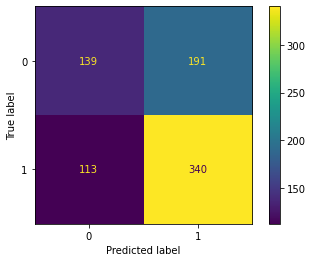

In [21]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_tfidf, y_train)
y_pred_tfidf = svm.predict(X_test_tfidf)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tfidf))
conf_mat.plot()
plt.show()

#### Feature importance



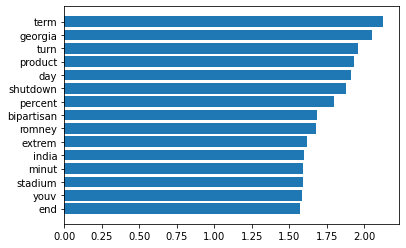

In [23]:
# Feature importance: ranking the coefficients of the SVM model
sorted_feat_vocab = sorted(TfV.vocabulary_.keys())
coef_svm = list(enumerate(svm.coef_[0]))
coef_svm = sorted(coef_svm, key = lambda k:k[1], reverse=True) # we sort the coefficients from highest to lowest
feature_names = []

for i,x in coef_svm:
    feature_names.append(sorted_feat_vocab[i])
coef_svm = [x[1] for x in coef_svm]

f_importances(coef_svm, feature_names, 15)

### 2.1.2 Random Forest 

#### Hyperparameter tuning

In [26]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_tfidf, y_train)
        y_pred_tfidf_valid = rfc.predict(X_valid_tfidf)
        acc = accuracy_score(y_valid, y_pred_tfidf_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.6360201511335013
ACCURACY SCORE with N_TREES = 100 is: 0.6309823677581864
ACCURACY SCORE with N_TREES = 200 is: 0.6322418136020151
ACCURACY SCORE with N_TREES = 500 is: 0.6234256926952141
ACCURACY SCORE with N_TREES = 1000 is: 0.6335012594458438
The maximum accuracy is reached with n_trees =  50


#### Predicting on the test set

Accuracy:  0.6155810983397191


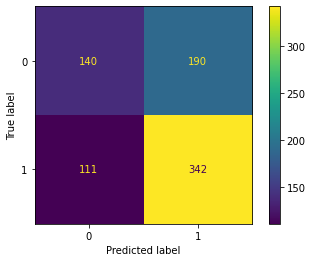

In [27]:
rfc = RandomForestClassifier(n_estimators = best_param, random_state = 16)
rfc.fit(X_train_tfidf, y_train)
y_pred_tfidf = rfc.predict(X_test_tfidf)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tfidf))
conf_mat.plot()
plt.show()

#### Feature importance

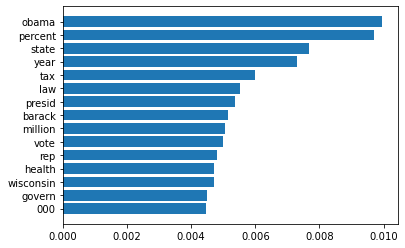

In [29]:
zipped_list = zip(sorted_feat_vocab, rfc.feature_importances_)

importances = sorted(zipped_list, key = lambda k:k[1], reverse = True) # we sort the coefficients from highest to lowest
coeffs = list(zip(*importances))[1]
names = list(zip(*importances))[0]
    
f_importances(coeffs, names, k = 15) 

## 2.2 Using a tf-idf document-term matrix with bigrams

In [24]:
# Creating a tf-idf feature matrix for bigrams
TfV = TfidfVectorizer(ngram_range = (2,2), min_df = 3)
X = TfV.fit_transform(stemmed_corpus_list)
tfidf_matrix = pd.DataFrame(X.toarray())

print(tfidf_matrix.shape)

(7993, 2601)


In [25]:
# Train-valid-test split
X_train_tfidf = X.toarray()[:df_train.shape[0]]
X_valid_tfidf = X.toarray()[df_train.shape[0]:-df_test.shape[0]]
X_test_tfidf = X.toarray()[-df_test.shape[0]:]

### 2.2.1 Support Vector Machine with linear kernel

#### Hyperparameter tuning

In [32]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_tfidf, y_train)
    y_pred_tfidf_valid = svm.predict(X_valid_tfidf)
    acc = accuracy_score(y_valid, y_pred_tfidf_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5465994962216625
ACCURACY SCORE with C = 1 is: 0.6007556675062973
ACCURACY SCORE with C = 10 is: 0.5579345088161209
ACCURACY SCORE with C = 100 is: 0.5440806045340051
The maximum accuracy is reached with C =  1


#### Predicting on the test set

Accuracy:  0.6040868454661558


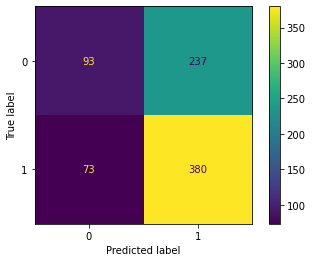

In [33]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_tfidf, y_train)
y_pred_tfidf = svm.predict(X_test_tfidf)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tfidf))
conf_mat.plot()
plt.show()

#### Feature importance



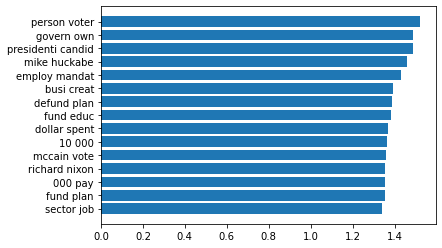

In [34]:
# Feature importance: ranking the coefficients of the SVM model
sorted_feat_vocab = sorted(TfV.vocabulary_.keys())
coef_svm = list(enumerate(svm.coef_[0]))
coef_svm = sorted(coef_svm, key = lambda k:k[1], reverse=True) # we sort the coefficients from highest to lowest
feature_names = []

for i,x in coef_svm:
    feature_names.append(sorted_feat_vocab[i])
coef_svm = [x[1] for x in coef_svm]

f_importances(coef_svm, feature_names, 15)

### 2.2.2 Random Forest 

#### Hyperparameter tuning

In [36]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_tfidf, y_train)
        y_pred_tfidf_valid = rfc.predict(X_valid_tfidf)
        acc = accuracy_score(y_valid, y_pred_tfidf_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.5604534005037783
ACCURACY SCORE with N_TREES = 100 is: 0.5692695214105793
ACCURACY SCORE with N_TREES = 200 is: 0.5692695214105793
ACCURACY SCORE with N_TREES = 500 is: 0.5730478589420654
ACCURACY SCORE with N_TREES = 1000 is: 0.5680100755667506
The maximum accuracy is reached with n_trees =  500


#### Predicting on the test set

Accuracy:  0.5874840357598978


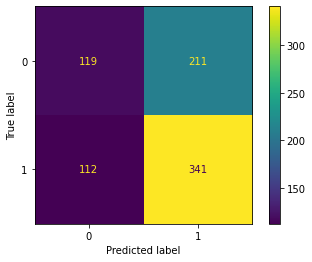

In [37]:
rfc = RandomForestClassifier(n_estimators = best_param, random_state = 16)
rfc.fit(X_train_tfidf, y_train)
y_pred_tfidf = rfc.predict(X_test_tfidf)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tfidf))
conf_mat.plot()
plt.show()

#### Feature importance

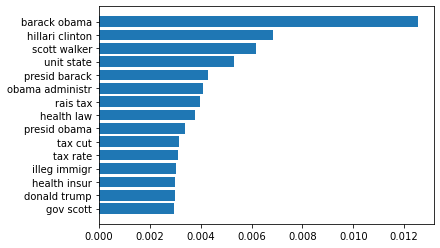

In [38]:
zipped_list = zip(sorted_feat_vocab, rfc.feature_importances_)

importances = sorted(zipped_list, key = lambda k:k[1], reverse = True) # we sort the coefficients from highest to lowest
coeffs = list(zip(*importances))[1]
names = list(zip(*importances))[0]
    
f_importances(coeffs, names, k = 15) 

## 2.3 Using a tf-idf document-term matrix with trigrams

In [26]:
# Creating tf-idf feature matrix with trigrams
TfV = TfidfVectorizer(ngram_range = (3,3), min_df = 3)
X = TfV.fit_transform(stemmed_corpus_list)
tfidf_matrix = pd.DataFrame(X.toarray())

print(tfidf_matrix.shape)

(7993, 495)


In [27]:
# Train-valid-test split
X_train_tfidf = X.toarray()[:df_train.shape[0]]
X_valid_tfidf = X.toarray()[df_train.shape[0]:-df_test.shape[0]]
X_test_tfidf = X.toarray()[-df_test.shape[0]:]

### 2.3.1 Support Vector Machine with linear kernel

#### Hyperparameter tuning

In [41]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_tfidf, y_train)
    y_pred_tfidf_valid = svm.predict(X_valid_tfidf)
    acc = accuracy_score(y_valid, y_pred_tfidf_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5415617128463476
ACCURACY SCORE with C = 1 is: 0.5642317380352645
ACCURACY SCORE with C = 10 is: 0.5604534005037783
ACCURACY SCORE with C = 100 is: 0.5591939546599496
The maximum accuracy is reached with C =  1


#### Predicting on the test set

Accuracy:  0.5925925925925926


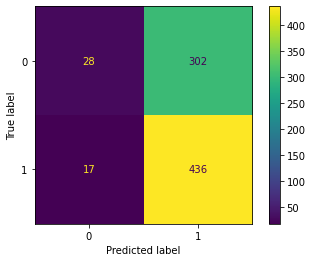

In [42]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_tfidf, y_train)
y_pred_tfidf = svm.predict(X_test_tfidf)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tfidf))
conf_mat.plot()
plt.show()

#### Feature importance



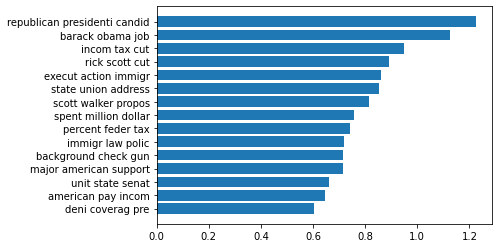

In [43]:
# Feature importance: ranking the coefficients of the SVM model
sorted_feat_vocab = sorted(TfV.vocabulary_.keys())
coef_svm = list(enumerate(svm.coef_[0]))
coef_svm = sorted(coef_svm, key = lambda k:k[1], reverse=True) # we sort the coefficients from highest to lowest
feature_names = []

for i,x in coef_svm:
    feature_names.append(sorted_feat_vocab[i])
coef_svm = [x[1] for x in coef_svm]

f_importances(coef_svm, feature_names, 15)

### 2.3.2 Random Forest 

#### Hyperparameter tuning

In [44]:
# Hyperparameter tuning
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_tfidf, y_train)
        y_pred_tfidf_valid = rfc.predict(X_valid_tfidf)
        acc = accuracy_score(y_valid, y_pred_tfidf_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.5591939546599496
ACCURACY SCORE with N_TREES = 100 is: 0.5642317380352645
ACCURACY SCORE with N_TREES = 200 is: 0.5654911838790933
ACCURACY SCORE with N_TREES = 500 is: 0.5629722921914357
ACCURACY SCORE with N_TREES = 1000 is: 0.5617128463476071
The maximum accuracy is reached with n_trees =  200


#### Predicting on the test set

Accuracy:  0.5849297573435505


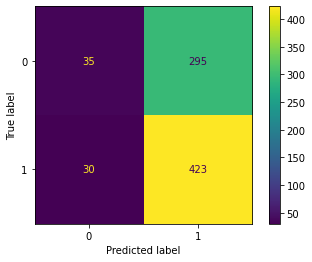

In [45]:
rfc = RandomForestClassifier(n_estimators = best_param, random_state = 16)
rfc.fit(X_train_tfidf, y_train)
y_pred_tfidf = rfc.predict(X_test_tfidf)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tfidf))
conf_mat.plot()
plt.show()

#### Feature importance

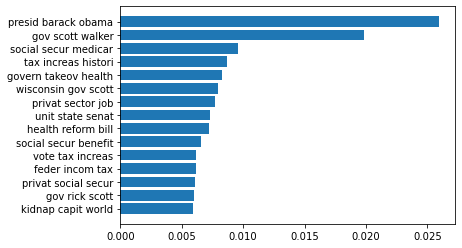

In [46]:
zipped_list = zip(sorted_feat_vocab, rfc.feature_importances_)

importances = sorted(zipped_list, key = lambda k:k[1], reverse = True) # we sort the coefficients from highest to lowest
coeffs = list(zip(*importances))[1]
names = list(zip(*importances))[0]
    
f_importances(coeffs, names, k = 15) 

## 2.4 Using a tf-idf document-term matrix with mixed unigrams and bigrams

In [28]:
# Creating a tf-idf feature matrix with both unigrams and bigrams
TfV = TfidfVectorizer(ngram_range = (1,2), min_df = 3)
X = TfV.fit_transform(stemmed_corpus_list)
tfidf_matrix = pd.DataFrame(X.toarray())

print(tfidf_matrix.shape)

(7993, 5663)


In [29]:
# Train-valid-test split
X_train_tfidf = X.toarray()[:df_train.shape[0]]
X_valid_tfidf = X.toarray()[df_train.shape[0]:-df_test.shape[0]]
X_test_tfidf = X.toarray()[-df_test.shape[0]:]

### 2.4.1 Support Vector Machine with linear kernel

#### Hyperparameter tuning

In [49]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_tfidf, y_train)
    y_pred_tfidf_valid = svm.predict(X_valid_tfidf)
    acc = accuracy_score(y_valid, y_pred_tfidf_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5566750629722922
ACCURACY SCORE with C = 1 is: 0.6448362720403022
ACCURACY SCORE with C = 10 is: 0.6158690176322418
ACCURACY SCORE with C = 100 is: 0.5906801007556675
ACCURACY SCORE with C = 1000 is: 0.5894206549118388
The maximum accuracy is reached with C =  1


#### Predicting on the test set

Accuracy:  0.6245210727969349


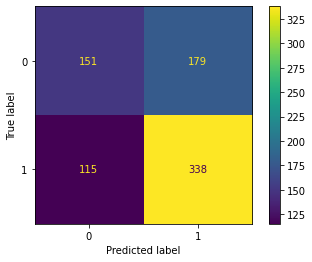

In [50]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_tfidf, y_train)
y_pred_tfidf = svm.predict(X_test_tfidf)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tfidf))
conf_mat.plot()
plt.show()

#### Feature importance



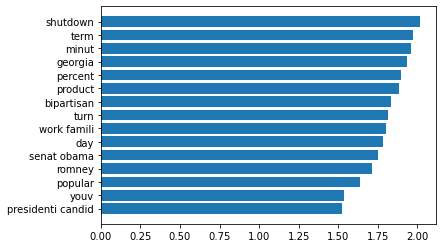

In [51]:
# Feature importance: ranking the coefficients of the SVM model
sorted_feat_vocab = sorted(TfV.vocabulary_.keys())
coef_svm = list(enumerate(svm.coef_[0]))
coef_svm = sorted(coef_svm, key = lambda k:k[1], reverse=True) # we sort the coefficients from highest to lowest
feature_names = []

for i,x in coef_svm:
    feature_names.append(sorted_feat_vocab[i])
coef_svm = [x[1] for x in coef_svm]

f_importances(coef_svm, feature_names, 15)

### 2.4.2 Random Forest 

#### Hyperparameter tuning

In [52]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_tfidf, y_train)
        y_pred_tfidf_valid = rfc.predict(X_valid_tfidf)
        acc = accuracy_score(y_valid, y_pred_tfidf_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.6322418136020151
ACCURACY SCORE with N_TREES = 100 is: 0.628463476070529
ACCURACY SCORE with N_TREES = 200 is: 0.628463476070529
ACCURACY SCORE with N_TREES = 500 is: 0.6322418136020151
ACCURACY SCORE with N_TREES = 1000 is: 0.6196473551637279
The maximum accuracy is reached with n_trees =  50


#### Predicting on the test set

Accuracy:  0.6283524904214559


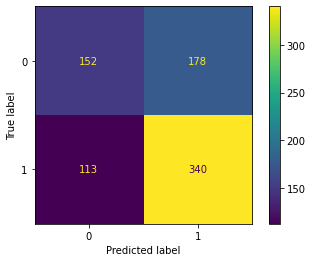

In [54]:
rfc = RandomForestClassifier(n_estimators = best_param, random_state = 16)
rfc.fit(X_train_tfidf, y_train)
y_pred_tfidf = rfc.predict(X_test_tfidf)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_tfidf))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_tfidf))
conf_mat.plot()
plt.show()

#### Feature importance

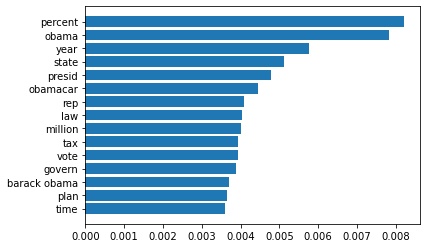

In [55]:
zipped_list = zip(sorted_feat_vocab, rfc.feature_importances_)

importances = sorted(zipped_list, key = lambda k:k[1], reverse = True) # we sort the coefficients from highest to lowest
coeffs = list(zip(*importances))[1]
names = list(zip(*importances))[0]
    
f_importances(coeffs, names, k = 15) 

## 2.5 Adding metadata to the previous best model trained on tf-idf (mixed unigrams and bigrams)

First we need to do some cleaning and make some design choices.
We embedded metadata to our models concatenating the statement string with the context string and merge the feature vectors obtained in this way with the merged OneHotEncoded matrices of *subjects*, *states*, *party*

### 2.5.1 Metadata matrices preparation

In [16]:
# Finding unique states
df_tot["state_info"] = df_tot["state_info"].str.rstrip()
pd.unique(df_tot["state_info"])

array(['Texas', 'Illinois', '', 'Wisconsin', 'New Jersey',
       'Massachusetts', 'Washington, D.C.', 'Oregon', 'New York',
       'California', 'Missouri', 'West Virginia', 'Florida', 'Arkansas',
       'New Hampshire', 'Ohio', 'Virginia', 'Arizona', 'Wyoming',
       'Rhode Island', 'Maryland', 'Georgia', 'Kentucky', 'Delaware',
       'Kansas', 'ohio', 'Colorado', 'New Mexico', 'Vermont', 'Alaska',
       'South Carolina', 'Iowa', 'Minnesota', 'Connecticut', 'Indiana',
       'Pennsylvania', 'North Carolina', 'Tennessee', 'Oklahoma',
       'Nevada', 'Virgina', 'None', 'Alabama', 'Russia', 'Louisiana',
       'District of Columbia', 'Nebraska', 'Michigan', 'Utah',
       'Mississippi', 'Rhode island', 'United Kingdom', 'Washington',
       'Montana', 'North Dakota', 'Maine', 'South Dakota', 'Virgiia',
       'Atlanta', 'Washington DC', 'Washington D.C.', 'PA - Pennsylvania',
       'Tex', 'Idaho', 'Washington state'], dtype=object)

In [17]:
# Cleaning the state_info column
state_dictionary = {
    "": "Unknown",
    "ohio" : "Ohio",
    "None" : "Unknown",
    "Washington state" : "Washington",
    "District of Columbia" : "Washington, D.C.",
    "Virginia director, Coalition to Stop Gun Violence" : "Virginia",
    "Virgiia" : "Virginia",
    "Atlanta" : "Georgia",
    "Washington DC" : "Washington, D.C.",
    "PA - Pennsylvania" : "Pennsylvania",
    "Tex" : "Texas",
    "the United States" : "USA",
    pd.NA: "Unknown"
}

df_tot["state_info"].replace(state_dictionary, inplace = True)

In [18]:
# Total number of unique states
len(pd.unique(df_tot["state_info"]))

56

In [19]:
# Finding unique party affiliations
pd.unique(df_tot["party_affiliation"])

array(['republican', 'democrat', 'none', 'activist', 'talk-show-host',
       'columnist', 'libertarian', 'independent', 'newsmaker',
       'organization', 'state-official', 'labor-leader', 'journalist',
       'business-leader', 'education-official', 'tea-party-member',
       'green', 'liberal-party-canada', 'government-body', 'Moderate',
       'constitution-party', 'county-commissioner'], dtype=object)

In [20]:
# Keeping only "republican", "democrat" and "none". Labeling the remaining with "other"
df_tot["party_affiliation"][(df_tot["party_affiliation"] != "democrat") & (df_tot["party_affiliation"] != "republican") & (df_tot["party_affiliation"] != "none")] = "other"

<ipython-input-20-83d76e2241df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tot["party_affiliation"][(df_tot["party_affiliation"] != "democrat") & (df_tot["party_affiliation"] != "republican") & (df_tot["party_affiliation"] != "none")] = "other"


In [21]:
df_tot.head()

,id,label,statement,subjects,state_info,party_affiliation,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,Texas,republican,a mailer
1,324.json,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,Denver
2,1123.json,0,Health care reform legislation is likely to ma...,health-care,Unknown,none,a news release
3,12465.json,1,The Chicago Bears have had more starting quart...,education,Wisconsin,republican,a an online opinion-piece
4,9741.json,1,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",Wisconsin,republican,an online video


In [22]:
# Finding unique subjects, splitting the multiple ones
unique_subjects = set()

for sub in pd.unique(df_tot["subjects"]):
    sub = sub.split(",")
    for s in sub:
        unique_subjects.add(s)
unique_subjects = sorted(unique_subjects)
print(len(unique_subjects))
print(unique_subjects)

142
['10-news-tampa-bay', 'Alcohol', 'abc-news-week', 'abortion', 'afghanistan', 'after-the-fact', 'agriculture', 'animals', 'autism', 'bankruptcy', 'baseball', 'bipartisanship', 'bush-administration', 'campaign-advertising', 'campaign-finance', 'candidates-biography', 'cap-and-trade', 'census', 'children', 'china', 'city-budget', 'city-government', 'civil-rights', 'climate-change', 'colbert-report', 'congress', 'congressional-rules', 'consumer-safety', 'corporations', 'corrections-and-updates', 'county-budget', 'county-government', 'crime', 'criminal-justice', 'death-penalty', 'debates', 'debt', 'deficit', 'disability', 'diversity', 'drugs', 'ebola', 'economy', 'education', 'elections', 'energy', 'environment', 'ethics', 'fake-news', 'families', 'federal-budget', 'financial-regulation', 'florida', 'florida-amendments', 'food', 'food-safety', 'foreign-policy', 'gambling', 'gas-prices', 'gays-and-lesbians', 'government-efficiency', 'government-regulation', 'guns', 'health-care', 'histor

In [23]:
# Manually creating a OneHotEncoded matrix for subjects
subjects_matrix = np.zeros((df_tot.shape[0],len(unique_subjects)))
subjects_matrix.shape

for i in range(df_tot.shape[0]):
    tmp_list = df_tot.iloc[i]["subjects"].split(",")
    for sub in tmp_list:
        j = unique_subjects.index(sub)
        subjects_matrix[i][j] = 1

print(subjects_matrix)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [24]:
# Creating a new column in the dataframe with the concatenation of the statement string + the context string
df_tot["statement_with_context"] = df_tot["context"] + " " + df_tot["statement"]
df_tot.head()

,id,label,statement,subjects,state_info,party_affiliation,context,statement_with_context
0,2635.json,0,Says the Annies List political group supports ...,abortion,Texas,republican,a mailer,a mailer Says the Annies List political group ...
1,324.json,1,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,Illinois,democrat,Denver,Denver Hillary Clinton agrees with John McCain...
2,1123.json,0,Health care reform legislation is likely to ma...,health-care,Unknown,none,a news release,a news release Health care reform legislation ...
3,12465.json,1,The Chicago Bears have had more starting quart...,education,Wisconsin,republican,a an online opinion-piece,a an online opinion-piece The Chicago Bears ha...
4,9741.json,1,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",Wisconsin,republican,an online video,an online video Says GOP primary opponents Gle...


In [25]:
# Reassigning the split dataframes
df_train = df_tot[:df_train.shape[0]]
df_valid = df_tot[df_train.shape[0]:-df_test.shape[0]]
df_test = df_tot[-df_test.shape[0]:]

In [26]:
# Creating a new corpus with the statement combined with the context
corpus_train_ctxt = list(df_train['statement_with_context'])
corpus_valid_ctxt = list(df_valid['statement_with_context'])
corpus_test_ctxt = list(df_test['statement_with_context'])
corpus_tot_ctxt = list(df_tot['statement_with_context'])

# Stemming
porter = PorterStemmer()
stemmed_corpus_ctxt = stem_corpus(porter, corpus_tot_ctxt)

stemmed_corpus_ctxt_list = [' '.join(x) for x in stemmed_corpus_ctxt]

In [27]:
# Creating a metadata matrix, which merges OneHotEncoded matrices of subjects, states, party and the random projections of the context
unique_states = sorted(pd.unique(df_tot['state_info']))
unique_party = sorted(pd.unique(df_tot['party_affiliation']))

subject_df = pd.DataFrame(subjects_matrix, columns = unique_subjects, index = list(range(len(stemmed_corpus))))
states_mat = OneHotEncoder().fit_transform(np.array(df_tot['state_info']).reshape(-1,1)).toarray()
states_df = pd.DataFrame(states_mat, columns = unique_states, index = list(range(len(stemmed_corpus))))
party_mat = OneHotEncoder().fit_transform(np.array(df_tot['party_affiliation']).reshape(-1,1)).toarray()
party_df = pd.DataFrame(party_mat, columns = unique_party, index = list(range(len(stemmed_corpus))))
md_df = subject_df.merge(states_df, left_index = True, right_index = True).merge(party_df, left_index = True, right_index = True)


### 2.5.2 Creating the new X matrix

In [28]:
TfV = TfidfVectorizer(ngram_range = (1,2), min_df = 3)
X = TfV.fit_transform(stemmed_corpus_ctxt_list)
tfidf_matrix = pd.DataFrame(X.toarray())

print(tfidf_matrix.shape)

(7993, 7102)


In [29]:
X_md = tfidf_matrix.merge(md_df, left_index=True, right_index=True)
print(X_md.shape)

(7993, 7304)


In [30]:
# Train-valid-test split
X_train_md = X_md.to_numpy()[:df_train.shape[0]]
X_valid_md = X_md.to_numpy()[df_train.shape[0]:-df_test.shape[0]]
X_test_md = X_md.to_numpy()[-df_test.shape[0]:]

### 2.5.3 Support Vector Machine with linear kernel

In [47]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_md, y_train)
    y_pred_md_valid = svm.predict(X_valid_md)
    acc = accuracy_score(y_valid, y_pred_md_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.6020151133501259
ACCURACY SCORE with C = 0.1 is: 0.6574307304785895
ACCURACY SCORE with C = 1 is: 0.6712846347607053
ACCURACY SCORE with C = 10 is: 0.6309823677581864
ACCURACY SCORE with C = 100 is: 0.610831234256927


KeyboardInterrupt: 

#### Predicting on the test set

Accuracy:  0.648786717752235


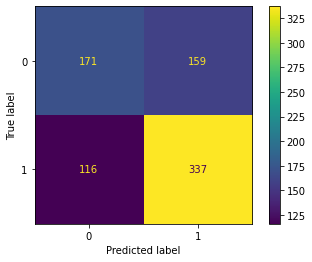

In [48]:
svm = SVC(kernel='linear', C = 1) # we select the best cost parameter according to our grid search above
svm.fit(X_train_md, y_train)
y_pred_md = svm.predict(X_test_md)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_md))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_md))
conf_mat.plot()
plt.show()

#### Feature importance



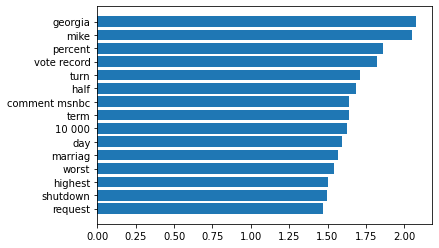

In [55]:
# Feature importance: ranking the coefficients of the SVM model
sorted_feat_vocab = sorted(TfV.vocabulary_.keys())
md_col = list(md_df.columns)
features = sorted_feat_vocab + md_col
coef_svm = list(enumerate(svm.coef_[0]))
coef_svm = sorted(coef_svm, key = lambda k:k[1], reverse=True) # we sort the coefficients from highest to lowest
feature_names = []

for i,x in coef_svm:
    feature_names.append(features[i])
coef_svm = [x[1] for x in coef_svm]

f_importances(coef_svm, feature_names, 15)

### 2.5.4 Random Forest 

#### Hyperparameter tuning

In [56]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_md, y_train)
        y_pred_md_valid = rfc.predict(X_valid_md)
        acc = accuracy_score(y_valid, y_pred_md_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.681360201511335
ACCURACY SCORE with N_TREES = 100 is: 0.6876574307304786
ACCURACY SCORE with N_TREES = 200 is: 0.6788413098236776
ACCURACY SCORE with N_TREES = 500 is: 0.6863979848866498
ACCURACY SCORE with N_TREES = 1000 is: 0.6914357682619647
The maximum accuracy is reached with n_trees =  1000


#### Predicting on the test set

Accuracy:  0.6679438058748404


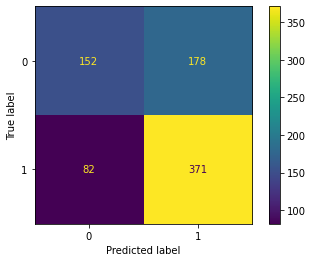

<Figure size 432x288 with 0 Axes>

In [79]:
rfc = RandomForestClassifier(n_estimators = 1000, random_state = 16)
rfc.fit(X_train_md, y_train)
y_pred_md = rfc.predict(X_test_md)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_md))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_md))
conf_mat.plot()
plt.show()

#### Feature importance

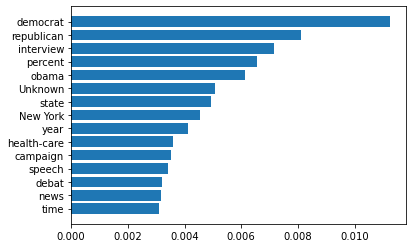

In [32]:
sorted_feat_vocab = sorted(TfV.vocabulary_.keys())
md_col = list(md_df.columns)
features = sorted_feat_vocab + md_col
zipped_list = zip(features, rfc.feature_importances_)

importances = sorted(zipped_list, key = lambda k:k[1], reverse = True) # we sort the coefficients from highest to lowest
coeffs = list(zip(*importances))[1]
names = list(zip(*importances))[0]
    
f_importances(coeffs, names, k = 15) 

### 2.5.8 Error analysis

In [57]:
# Finding the misclassified sentences
mis = []
for i in range(len(y_test)):
    if y_test[i] != y_pred_md[i]:
        mis.append(df_test.iloc[i])

In [58]:
df_mis = pd.DataFrame(mis)
df_mis.head()

,id,label,statement,subjects,state_info,party_affiliation,context
0,11972.json,1,Building a wall on the U.S.-Mexico border will...,immigration,Texas,republican,Radio interview
1,11685.json,0,Wisconsin is on pace to double the number of l...,jobs,Wisconsin,democrat,a news conference
16,10064.json,0,Says Charlie Crist is embroiled in a fraud cas...,"jobs,state-budget",,republican,a TV ad
18,1051.json,1,Contends that President Obama literally said (...,"climate-change,energy",Indiana,republican,MSNBC interview.
21,9800.json,0,"Under Rosemary Lehmberg, the Travis County D.A...","crime,criminal-justice",Alaska,republican,a commentary


In [59]:
# Printing all the misclassified statements with their wrong prediction.
for i,x in df_mis.iterrows():
    print(x['label'], x['statement'])

1 Building a wall on the U.S.-Mexico border will take literally years.
0 Wisconsin is on pace to double the number of layoffs this year.
0 Says Charlie Crist is embroiled in a fraud case for steering taxpayer money to a de facto Ponzi scheme.
1 Contends that President Obama literally said (if) his cap-and-trade proposals were to pass, that utility rates, his words now, would, necessarily skyrocket.
0 Under Rosemary Lehmberg, the Travis County D.A.s office convened the grand jury that indicted Rick Perry.
1 In 1993, Newt Gingrich first advocated for the individual mandate in health care. And as recently as May of this year, he was still advocating for it.
0 A proposed tax to fund transportation projects would spend $90,000 to take a single vehicle off the road during the morning and afternoon commute.
0 When undocumented children are picked up at the border and told to appear later in court ... 90 percent do not then show up.
1 Hes the only candidate whos balanced budgets and brought jo

#### Analysis on party affiliation attribute

In [83]:
# Analysis on the predicted class w.r.t. the party
party_counts = {
    'democrat': {0: 0, 1: 0},
    'republican': {0: 0, 1: 0}
}
for i in range(len(y_pred_md)):
    party = df_test.iloc[i]['party_affiliation']
    if party in party_counts.keys():
        party_counts[party][int(y_pred_md
    [i])] += 1

party_counts_perc = {}
for k in party_counts.keys():
    tot = party_counts[k][0]+party_counts[k][1]
    party_counts_perc[k] = {0: '{:.2f}%'.format(party_counts[k][0]/tot*100),
        1: '{:.2f}%'.format(party_counts[k][1]/tot*100)
    }

print('Prediction counts wrt party:', party_counts)
print('Prediction percentage wrt party:', party_counts_perc)

Prediction counts wrt party: {'democrat': {0: 21, 1: 233}, 'republican': {0: 131, 1: 200}}
Prediction percentage wrt party: {'democrat': {0: '8.27%', 1: '91.73%'}, 'republican': {0: '39.58%', 1: '60.42%'}}


In [73]:
# Error analysis
tot = df_mis['party_affiliation'].value_counts()['democrat']
party_mis = {0: 0, 1: 0}
for i, row in df_mis.iterrows():
    if row['party_affiliation'] == 'democrat':
        party_mis[y_pred_md[i]] += 1

party_mis_perc = {0: '{:.2f}%'.format(party_mis[0]/tot*100),
        1: '{:.2f}%'.format(party_mis[1]/tot*100)}

print('Misclassified counts for democrat:', party_mis)
print('Misclassified percentage for democrat:', party_mis_perc)


Misclassified counts for democrat: {0: 11, 1: 57}
Misclassified percentage for democrat: {0: '16.18%', 1: '83.82%'}


#### Analysis on the word *obama*

In [85]:
# Analysis on the predicted class w.r.t. the word 'obama'
obama_counts = {0: 0, 1: 0}
stemmed_test = stem_corpus(porter, corpus_test_ctxt) # list of list of stemmed words

for i in range(len(y_pred_md)):
    if 'obama' in stemmed_test[i]:
        obama_counts[int(y_pred_md[i])] += 1

tot = obama_counts[0] + obama_counts[1]
obama_counts_perc = {0: '{:.2f}%'.format(obama_counts[0]/tot*100),
        1: '{:.2f}%'.format(obama_counts[1]/tot*100)
    }

print('Prediction counts wrt "obama":', obama_counts)
print('Prediction percentage wrt "obama":', obama_counts_perc)

Prediction counts wrt "obama": {0: 47, 1: 19}
Prediction percentage wrt "obama": {0: '71.21%', 1: '28.79%'}


In [86]:
# Error analysis
obama_mis = {0: 0, 1: 0}
for i in df_mis.index:
    if 'obama' in stemmed_test[i]:
        obama_mis[int(y_pred_md[i])] += 1

tot = obama_mis[0]+obama_mis[1]
obama_mis_perc = {0: '{:.2f}%'.format(obama_mis[0]/tot*100),
        1: '{:.2f}%'.format(obama_mis[1]/tot*100)}
print('Misclassified counts wrt "obama":', obama_mis)
print('Misclassified percentage for "obama":', obama_mis_perc)

Misclassified counts wrt "obama": {0: 20, 1: 4}
Misclassified percentage for "obama": {0: '83.33%', 1: '16.67%'}


#### Analysis on the word *interview* (probably inside the context feature)

In [68]:
# Analysis on the predicted class w.r.t. the word 'interview'
inter_counts = {0: 0, 1: 0}

for i in range(len(y_pred_md)):
    if 'interview' in stemmed_test[i]:
        inter_counts[int(y_pred_md[i])] += 1

tot = inter_counts[0] + inter_counts[1]
inter_counts_perc = {0: '{:.2f}%'.format(inter_counts[0]/tot*100),
        1: '{:.2f}%'.format(inter_counts[1]/tot*100)
    }

print('Prediction counts wrt "interview":', inter_counts)
print('Prediction percentage wrt "interview":', inter_counts_perc)

Prediction counts wrt "interview": {0: 33, 1: 86}
Prediction percentage wrt "interview": {0: '27.73%', 1: '72.27%'}


In [69]:
# Error analysis
inter_mis = {0: 0, 1: 0}
for i in df_mis.index:
    if 'interview' in stemmed_test[i]:
        inter_mis[int(y_pred_md[i])] += 1

tot = inter_mis[0]+inter_mis[1]
inter_mis_perc = {0: '{:.2f}%'.format(inter_mis[0]/tot*100),
        1: '{:.2f}%'.format(inter_mis[1]/tot*100)}
print('Misclassified counts wrt "interview":', inter_mis)
print('Misclassified percentage for "interview":', inter_mis_perc)     

Misclassified counts wrt "interview": {0: 18, 1: 30}
Misclassified percentage for "interview": {0: '37.50%', 1: '62.50%'}


#### Analysis on the word *percent*

In [70]:
# Analysis on the predicted class w.r.t. the word 'percent'
perc_counts = {0: 0, 1: 0}

for i in range(len(y_pred_md)):
    if 'percent' in stemmed_test[i]:
        perc_counts[int(y_pred_md[i])] += 1

tot = perc_counts[0] + perc_counts[1]
perc_counts_perc = {0: '{:.2f}%'.format(perc_counts[0]/tot*100),
        1: '{:.2f}%'.format(perc_counts[1]/tot*100)
    }

print('Prediction counts wrt "percent":', perc_counts)
print('Prediction percentage wrt "percent":', perc_counts_perc)

Prediction counts wrt "percent": {0: 11, 1: 72}
Prediction percentage wrt "percent": {0: '13.25%', 1: '86.75%'}


In [76]:
# Error analysis
perc_mis = {0: 0, 1: 0}
for i in df_mis.index:
    if 'percent' in stemmed_test[i]:
        perc_mis[int(y_pred_md[i])] += 1

tot = perc_mis[0]+perc_mis[1]
perc_mis_perc = {0: '{:.2f}%'.format(perc_mis[0]/tot*100),
        1: '{:.2f}%'.format(perc_mis[1]/tot*100)}
print('Misclassified counts wrt "percent":', perc_mis)
print('Misclassified percentage for "percent":', perc_mis_perc)    

Misclassified counts wrt "percent": {0: 4, 1: 20}
Misclassified percentage for "percent": {0: '16.67%', 1: '83.33%'}


# 3. Word2Vec

In order to get sentence embeddings for each statement we computed either a simple or a weigthed (with tfidf as weight) average of the Word2Vec feature vector of each word in a statement.

## 3.1 Pre-trained Google news model with simple average

In [59]:
# Loading pre-trained model on google news.
wv_google = api.load("word2vec-google-news-300")

In [32]:
# We create a corpus which is tokenized but not stemmed (otherwise there won't be many words in the google-news vocabulary)
tokenized_corpus = [tokenize_sent(sent) for sent in corpus_tot]

In [132]:
# Creating the matrix of the average vectors of each statement in the corpus
google_vocab = set(wv_google.index_to_key)
sents_mat_ggl = np.zeros((len(tokenized_corpus), 300))

for i in range(len(tokenized_corpus)):
    c = 0
    for word in tokenized_corpus[i]:
        if word in google_vocab:
            sents_mat_ggl[i] += wv_google[word]
            c += 1
    if c != 0:
        sents_mat_ggl[i] = sents_mat_ggl[i] / c

In [133]:
# Train-valid-test split
X_train_ggl = sents_mat_ggl[:df_train.shape[0]]
X_valid_ggl = sents_mat_ggl[df_train.shape[0]:-df_test.shape[0]]
X_test_ggl = sents_mat_ggl[-df_test.shape[0]:]

### 3.1.1 Support Vector Machine with linear kernel

#### Hyperparameter tuning

In [62]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_ggl, y_train)
    y_pred_ggl_valid = svm.predict(X_valid_ggl)
    acc = accuracy_score(y_valid, y_pred_ggl_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5428211586901763
ACCURACY SCORE with C = 0.1 is: 0.6372795969773299
ACCURACY SCORE with C = 1 is: 0.6309823677581864
ACCURACY SCORE with C = 10 is: 0.6209068010075567
ACCURACY SCORE with C = 100 is: 0.6171284634760705
ACCURACY SCORE with C = 1000 is: 0.6171284634760705
The maximum accuracy is reached with C =  0.1


#### Predicting on the test set

Accuracy:  0.6309067688378033


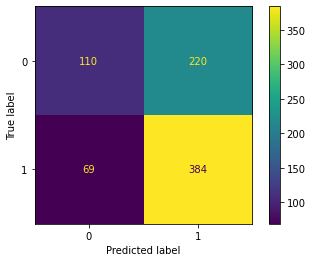

In [63]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_ggl, y_train)
y_pred_ggl = svm.predict(X_test_ggl)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_ggl))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_ggl))
conf_mat.plot()
plt.show()

### 3.1.2 Random Forest 

#### Hyperparameter tuning

In [35]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_ggl, y_train)
        y_pred_ggl_valid = rfc.predict(X_valid_ggl)
        acc = accuracy_score(y_valid, y_pred_ggl_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.6221662468513854
ACCURACY SCORE with N_TREES = 100 is: 0.6423173803526449
ACCURACY SCORE with N_TREES = 200 is: 0.6423173803526449
ACCURACY SCORE with N_TREES = 500 is: 0.6297229219143576
ACCURACY SCORE with N_TREES = 1000 is: 0.6259445843828715
The maximum accuracy is reached with n_trees =  100


#### Predicting on the test set

Accuracy:  0.6015325670498084


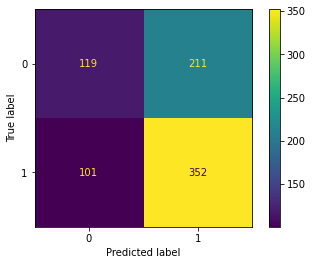

In [36]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 16)
rfc.fit(X_train_ggl, y_train)
y_pred_ggl = rfc.predict(X_test_ggl)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_ggl))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_ggl))
conf_mat.plot()
plt.show()

## 3.2 Model trained on our corpus with simple average

In [30]:
# In order to train a Word2Vec model we need to use the LineSentence class which requires a txt file of the corpus
stemmed_corpus_string = ''

for sent in stemmed_corpus_list:
    stemmed_corpus_string += sent + '\n'

with open("stemmed_corpus_string.txt",'w',encoding = 'utf-8') as f:
    f.write(stemmed_corpus_string)

In [127]:
# Training word2vec model using our corpus
sentences=LineSentence("stemmed_corpus_string.txt")

vector_size = 100
w2v_liar = Word2Vec(sentences = sentences, vector_size=vector_size, window = 5, sg=0, min_count=1, negative = 5)

In [87]:
# Creating the matrix of the average vectors of each statement in the corpus
sents_mat = np.zeros((len(stemmed_corpus), vector_size))

for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        sents_mat[i] += w2v_liar.wv[word]
    sents_mat[i] = sents_mat[i] / len(stemmed_corpus[i])

In [88]:
# Train-valid-test split
X_train_s2v = sents_mat[:df_train.shape[0]]
X_valid_s2v = sents_mat[df_train.shape[0]:-df_test.shape[0]]
X_test_s2v = sents_mat[-df_test.shape[0]:]

### 3.2.1 Support Vector Machine with linear kernel

#### Hyperparameter tuning

In [81]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_s2v, y_train)
    y_pred_s2v_valid = svm.predict(X_valid_s2v)
    acc = accuracy_score(y_valid, y_pred_s2v_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5289672544080605
ACCURACY SCORE with C = 1 is: 0.5465994962216625
ACCURACY SCORE with C = 10 is: 0.5617128463476071
ACCURACY SCORE with C = 100 is: 0.5919395465994962
ACCURACY SCORE with C = 1000 is: 0.5994962216624685
ACCURACY SCORE with C = 10000 is: 0.610831234256927
ACCURACY SCORE with C = 100000 is: 0.6171284634760705
The maximum accuracy is reached with C =  100000


#### Predicting on the test set

Accuracy:  0.5849297573435505


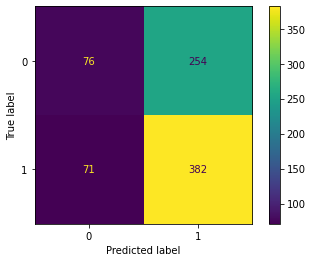

In [82]:
svm = SVC(kernel='linear', C = 1000) # we select the best cost parameter according to our grid search above
svm.fit(X_train_s2v, y_train)
y_pred_s2v = svm.predict(X_test_s2v)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_s2v))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_s2v))
conf_mat.plot()
plt.show()

### 3.2.2 Random Forest 

#### Hyperparameter tuning

In [83]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_s2v, y_train)
        y_pred_s2v_valid = rfc.predict(X_valid_s2v)
        acc = accuracy_score(y_valid, y_pred_s2v_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.5982367758186398
ACCURACY SCORE with N_TREES = 100 is: 0.6007556675062973
ACCURACY SCORE with N_TREES = 200 is: 0.6083123425692695
ACCURACY SCORE with N_TREES = 500 is: 0.6083123425692695
ACCURACY SCORE with N_TREES = 1000 is: 0.6083123425692695
The maximum accuracy is reached with n_trees =  200


#### Predicting on the test set

Accuracy:  0.5900383141762452


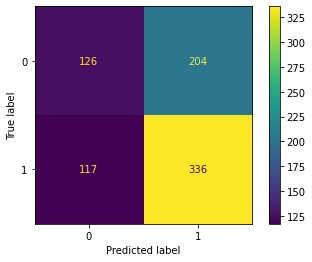

In [84]:
rfc = RandomForestClassifier(n_estimators = best_param, random_state = 16)
rfc.fit(X_train_s2v, y_train)
y_pred_s2v = rfc.predict(X_test_s2v)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_s2v))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_s2v))
conf_mat.plot()
plt.show()

## 3.3 Model trained on our corpus with weighted average

In [98]:
# We create a new tf-idf matrix to retrieve the weights
TfV = TfidfVectorizer(vocabulary=set(w2v_liar.wv.index_to_key))
X = TfV.fit_transform(stemmed_corpus_list)
vocab = set(TfV.vocabulary_.keys())
tfidf_matrix = pd.DataFrame(X.toarray(), index = list(range(X.shape[0])), columns = sorted(vocab))

# Creating the matrix of the weighted average vectors of each statement in the corpus
sents_mat = np.zeros((len(stemmed_corpus), vector_size))
for i in range(len(stemmed_corpus)):
    c = 0
    for word in stemmed_corpus[i]:
        sents_mat[i] += w2v_liar.wv[word]*tfidf_matrix.iloc[i][word]
        c += tfidf_matrix.iloc[i][word]
    if c != 0:
        sents_mat[i] = sents_mat[i] / c

In [103]:
# Train-valid-test split
X_train_s2v = sents_mat[:df_train.shape[0]]
X_valid_s2v = sents_mat[df_train.shape[0]:-df_test.shape[0]]
X_test_s2v = sents_mat[-df_test.shape[0]:]

### 3.3.1 Support Vector Machine with linear kernel

#### Hyperparameter tuning

In [105]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_s2v, y_train)
    y_pred_s2v_valid = svm.predict(X_valid_s2v)
    acc = accuracy_score(y_valid, y_pred_s2v_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5277078085642317
ACCURACY SCORE with C = 1 is: 0.5453400503778337
ACCURACY SCORE with C = 10 is: 0.5516372795969773
ACCURACY SCORE with C = 100 is: 0.5717884130982368
ACCURACY SCORE with C = 1000 is: 0.5957178841309824
The maximum accuracy is reached with C =  1000


#### Predicting on the test set

Accuracy:  0.5747126436781609


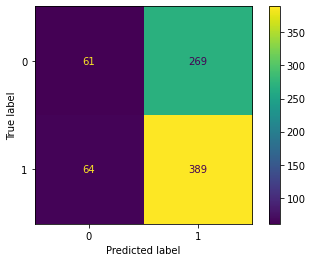

In [107]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_s2v, y_train)
y_pred_s2v = svm.predict(X_test_s2v)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_s2v))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_s2v))
conf_mat.plot()
plt.show()

### 3.3.2 Random Forest 

#### Hyperparameter tuning

In [108]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_s2v, y_train)
        y_pred_s2v_valid = rfc.predict(X_valid_s2v)
        acc = accuracy_score(y_valid, y_pred_s2v_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.5957178841309824
ACCURACY SCORE with N_TREES = 100 is: 0.5969773299748111
ACCURACY SCORE with N_TREES = 200 is: 0.6032745591939547
ACCURACY SCORE with N_TREES = 500 is: 0.5906801007556675
ACCURACY SCORE with N_TREES = 1000 is: 0.593198992443325
The maximum accuracy is reached with n_trees =  200


#### Predicting on the test set

Accuracy:  0.5747126436781609


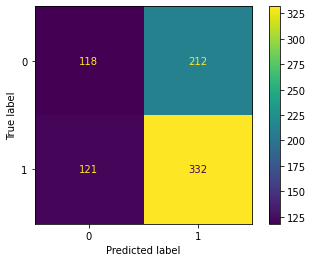

In [109]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 16)
rfc.fit(X_train_s2v, y_train)
y_pred_s2v = rfc.predict(X_test_s2v)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_s2v))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_s2v))
conf_mat.plot()
plt.show()

## 3.4 Exploring Word2Vec bigrams

The gensim Phrases module can find common bigrams in the corpus, like multi-word expressions such as "political_group", and treat them as a word.

In [110]:
# Finding common bigrams
statements_tokenized = [tokenize_sent(x) for x in corpus_tot]
phrase_model = Phrases(statements_tokenized, min_count=1, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)
statements_bigrams = phrase_model[statements_tokenized]

In [111]:
# Creating the txt file for LineSentence
tkn_statements_strings = ''
for sent in [' '.join(x) for x in statements_bigrams]:
    tkn_statements_strings += sent + '\n'

with open("tkn_statements_strings.txt",'w',encoding = 'utf-8') as f:
    f.write(tkn_statements_strings)

In [112]:
# Training word2vec model using our corpus
sentences=LineSentence("tkn_statements_strings.txt") #TODO: load our sentences in the appropriate way
vector_size = 100
w2v_liar = Word2Vec(sentences = sentences, vector_size=vector_size, window = 5, sg=0, min_count=1, negative = 5)

In [116]:
# Creating the matrix of the average vectors of each statement in the corpus
sents_bigr_mat = np.zeros((len(statements_bigrams), vector_size))

for i in range(len(statements_bigrams)):
    for word in statements_bigrams[i]:
        sents_bigr_mat[i] += w2v_liar.wv[word]
    sents_bigr_mat[i] = sents_bigr_mat[i] / len(statements_bigrams[i])

In [120]:
# Train-valid-test split
X_train_big = sents_bigr_mat[:df_train.shape[0]]
X_valid_big = sents_bigr_mat[df_train.shape[0]:-df_test.shape[0]]
X_test_big = sents_bigr_mat[-df_test.shape[0]:]

### 3.4.1 Support Vector Machine with linear kernel

#### Hyperparameter tuning

In [121]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_big, y_train)
    y_pred_big_valid = svm.predict(X_valid_big)
    acc = accuracy_score(y_valid, y_pred_big_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5277078085642317
ACCURACY SCORE with C = 1 is: 0.5277078085642317
ACCURACY SCORE with C = 10 is: 0.5277078085642317
ACCURACY SCORE with C = 100 is: 0.5277078085642317
ACCURACY SCORE with C = 1000 is: 0.5289672544080605
The maximum accuracy is reached with C =  1000


#### Predicting on the test set

Accuracy:  0.578544061302682


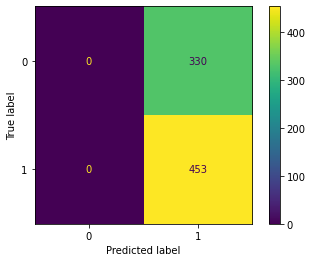

In [124]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_big, y_train)
y_pred_big = svm.predict(X_test_big)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_big))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_big))
conf_mat.plot()
plt.show()

### 3.4.2 Random Forest 

#### Hyperparameter tuning

In [123]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_big, y_train)
        y_pred_big_valid = rfc.predict(X_valid_big)
        acc = accuracy_score(y_valid, y_pred_big_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.5491183879093199
ACCURACY SCORE with N_TREES = 100 is: 0.5680100755667506
ACCURACY SCORE with N_TREES = 200 is: 0.5730478589420654
ACCURACY SCORE with N_TREES = 500 is: 0.570528967254408
ACCURACY SCORE with N_TREES = 1000 is: 0.5730478589420654
The maximum accuracy is reached with n_trees =  200


#### Predicting on the test set

Accuracy:  0.5759897828863346


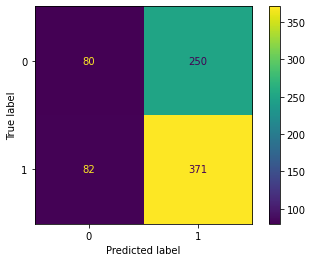

In [125]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 16)
rfc.fit(X_train_big, y_train)
y_pred_big = rfc.predict(X_test_big)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_big))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_big))
conf_mat.plot()
plt.show()

## 3.5 Adding metadata to the previous best model trained on Word2Vec embeddings (Google news)

### 3.5.1 Creating the new X matrix

In [60]:
tokenized_corpus = [tokenize_sent(sent) for sent in corpus_tot_ctxt]

In [61]:
google_vocab = set(wv_google.index_to_key)
sents_mat_ggl_ctxt = np.zeros((len(tokenized_corpus), 300))

for i in range(len(tokenized_corpus)):
    c = 0
    for word in tokenized_corpus[i]:
        if word in google_vocab:
            sents_mat_ggl_ctxt[i] += wv_google[word]
            c += 1
    if c != 0:
        sents_mat_ggl_ctxt[i] = sents_mat_ggl_ctxt[i] / c

In [63]:
# Creating the new merged matrix X with metadata
X_df = pd.DataFrame(sents_mat_ggl_ctxt, index = list(range(sents_mat_ggl_ctxt.shape[0])), columns = list(range(sents_mat_ggl_ctxt.shape[1])))
X_md = X_df.merge(md_df, left_index=True, right_index=True)
X_md.shape

(7993, 502)

In [64]:
# Train-valid-test split
X_train_md = X_md.to_numpy()[:df_train.shape[0]]
X_valid_md = X_md.to_numpy()[df_train.shape[0]:-df_test.shape[0]]
X_test_md = X_md.to_numpy()[-df_test.shape[0]:]

### 3.5.2 Support Vector Machine with linear kernel

In [65]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_md, y_train)
    y_pred_md_valid = svm.predict(X_valid_md)
    acc = accuracy_score(y_valid, y_pred_md_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.6410579345088161
ACCURACY SCORE with C = 0.1 is: 0.672544080604534
ACCURACY SCORE with C = 1 is: 0.6649874055415617
ACCURACY SCORE with C = 10 is: 0.6511335012594458
ACCURACY SCORE with C = 100 is: 0.6536523929471033
The maximum accuracy is reached with C =  0.1


#### Predicting on the test set

Accuracy:  0.6768837803320562


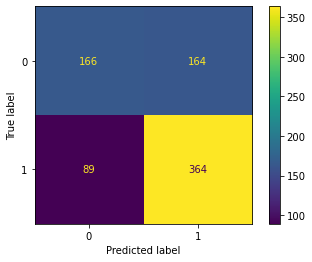

In [66]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_md, y_train)
y_pred_md = svm.predict(X_test_md)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_md))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_md))
conf_mat.plot()
plt.show()

### 3.5.3 Random Forest 

#### Hyperparameter tuning

In [68]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_md, y_train)
        y_pred_md_valid = rfc.predict(X_valid_md)
        acc = accuracy_score(y_valid, y_pred_md_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.6309823677581864
ACCURACY SCORE with N_TREES = 100 is: 0.6171284634760705
ACCURACY SCORE with N_TREES = 200 is: 0.6297229219143576
ACCURACY SCORE with N_TREES = 500 is: 0.6624685138539043
ACCURACY SCORE with N_TREES = 1000 is: 0.6700251889168766
The maximum accuracy is reached with n_trees =  1000


#### Predicting on the test set

Accuracy:  0.6577266922094508


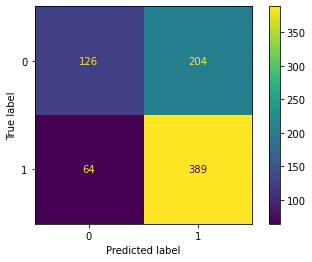

In [69]:
rfc = RandomForestClassifier(n_estimators = best_param, random_state = 16)
rfc.fit(X_train_md, y_train)
y_pred_md = rfc.predict(X_test_md)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_md))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_md))
conf_mat.plot()
plt.show()

## 3.6 Trying different Word2Vec parameters

In [31]:
# Different models with different parameters
sentences=LineSentence("stemmed_corpus_string.txt")
### DIFFERENT SIZES ###
w2v_50 = Word2Vec(sentences = sentences, vector_size=50, window = 5, sg=0, min_count=1, negative = 5)
w2v_200 = Word2Vec(sentences = sentences, vector_size=200, window = 5, sg=0, min_count=1, negative = 5)
w2v_300 = Word2Vec(sentences = sentences, vector_size=300, window = 5, sg=0, min_count=1, negative = 5)

### DIFFERENT WINDOWS ###
w2v_w10 = Word2Vec(sentences = sentences, vector_size=100, window = 10, sg=0, min_count=1, negative = 5)
w2v_w2 = Word2Vec(sentences = sentences, vector_size=100, window = 2, sg=0, min_count=1, negative = 5)

### WITH SG ###
w2v_sg = Word2Vec(sentences = sentences, vector_size=100, window = 5, sg=1, min_count=1, negative = 5)

### DIFFERENT MIN_COUNT ###
w2v_mc3 = Word2Vec(sentences = sentences, vector_size=100, window = 5, sg=0, min_count=3, negative = 5)
w2v_mc5 = Word2Vec(sentences = sentences, vector_size=100, window = 5, sg=0, min_count=5, negative = 5)

### DIFFERENT NEGATIVE SAMPLING ###
w2v_noneg = Word2Vec(sentences = sentences, vector_size=100, window = 5, sg=0, min_count=1, negative = 0)
w2v_neg10 = Word2Vec(sentences = sentences, vector_size=100, window = 5, sg=0, min_count=1, negative = 10)
w2v_neg20 = Word2Vec(sentences = sentences, vector_size=100, window = 5, sg=0, min_count=1, negative = 20)

In [45]:
accs_svm = {
    'sizes': [],
    'windows': [],
    'sg': 0,
    'min_counts': [],
    'neg_sample': []
}

accs_rfc = {
    'sizes': [],
    'windows': [],
    'sg': 0,
    'min_counts': [],
    'neg_sample': []
}

### 3.6.1 Different vector sizes

In [27]:
### DIFFERENT SIZES MODELS SENTENCE MATRICES ###
sents_mat_50 = np.zeros((len(stemmed_corpus), 50))
sents_mat_200 = np.zeros((len(stemmed_corpus), 200))
sents_mat_300= np.zeros((len(stemmed_corpus), 300))

for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        sents_mat_50[i] += w2v_50.wv[word]
        sents_mat_200[i] += w2v_200.wv[word]
        sents_mat_300[i] += w2v_300.wv[word]
    sents_mat_50[i] = sents_mat_50[i] / len(stemmed_corpus[i])
    sents_mat_200[i] = sents_mat_200[i] / len(stemmed_corpus[i])
    sents_mat_300[i] = sents_mat_300[i] / len(stemmed_corpus[i])

In [28]:
# Train-valid-test split
X_train_50 = sents_mat_50[:df_train.shape[0]]
X_train_200 = sents_mat_200[:df_train.shape[0]]
X_train_300 = sents_mat_300[:df_train.shape[0]]

X_valid_50 = sents_mat_50[df_train.shape[0]:-df_test.shape[0]]
X_valid_200 = sents_mat_200[df_train.shape[0]:-df_test.shape[0]]
X_valid_300 = sents_mat_300[df_train.shape[0]:-df_test.shape[0]]

X_test_50 = sents_mat_50[-df_test.shape[0]:]
X_test_200 = sents_mat_200[-df_test.shape[0]:]
X_test_300 = sents_mat_300[-df_test.shape[0]:]

#### SVM

In [33]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = {
    50: [],
    200: [],
    300: []
}
for cost in [0.01, 0.1, 1, 10, 100, 1000]:
    svm_50 = SVC(kernel='linear', C = cost)
    svm_200 = SVC(kernel='linear', C = cost)
    svm_300 = SVC(kernel='linear', C = cost)

    svm_50.fit(X_train_50, y_train)
    svm_200.fit(X_train_200, y_train)
    svm_300.fit(X_train_300, y_train)

    y_pred_50_valid = svm_50.predict(X_valid_50)
    y_pred_200_valid = svm_200.predict(X_valid_200)
    y_pred_300_valid = svm_300.predict(X_valid_300)

    acc_50 = accuracy_score(y_valid, y_pred_50_valid)
    acc_200 = accuracy_score(y_valid, y_pred_200_valid)
    acc_300 = accuracy_score(y_valid, y_pred_300_valid)

    grid_params[50].append((cost, acc_50))
    grid_params[200].append((cost, acc_200))
    grid_params[300].append((cost, acc_300))

    print(f"ACCURACY SCORE for size = 50 with C = {cost} is: {acc_50}")
    print(f"ACCURACY SCORE for size = 200 with C = {cost} is: {acc_200}")        
    print(f"ACCURACY SCORE for size = 300 with C = {cost} is: {acc_300}")

for k in grid_params.keys():
    best_param = max(grid_params[k], key = lambda x: x[1])[0]
    print(f"The maximum accuracy for size = {k} is reached with C = {best_param}")

ACCURACY SCORE for size = 50 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for size = 200 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for size = 300 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for size = 50 with C = 0.1 is: 0.5327455919395466
ACCURACY SCORE for size = 200 with C = 0.1 is: 0.5277078085642317
ACCURACY SCORE for size = 300 with C = 0.1 is: 0.5277078085642317
ACCURACY SCORE for size = 50 with C = 1 is: 0.5465994962216625
ACCURACY SCORE for size = 200 with C = 1 is: 0.5465994962216625
ACCURACY SCORE for size = 300 with C = 1 is: 0.5428211586901763
ACCURACY SCORE for size = 50 with C = 10 is: 0.575566750629723
ACCURACY SCORE for size = 200 with C = 10 is: 0.5566750629722922
ACCURACY SCORE for size = 300 with C = 10 is: 0.5516372795969773
ACCURACY SCORE for size = 50 with C = 100 is: 0.5894206549118388
ACCURACY SCORE for size = 200 with C = 100 is: 0.5818639798488665
ACCURACY SCORE for size = 300 with C = 100 is: 0.5743073047858942
ACCURACY SCORE for siz

In [46]:
# PREDICTING ON TEST SET
svm_50 = SVC(kernel='linear', C = 100) # we select the best cost parameter according to our grid search above
svm_200 = SVC(kernel='linear', C = 1000) 
svm_300 = SVC(kernel='linear', C = 1000) 

svm_50.fit(X_train_50, y_train)
svm_200.fit(X_train_200, y_train)
svm_300.fit(X_train_300, y_train)

y_pred_50 = svm_50.predict(X_test_50)
y_pred_200 = svm_200.predict(X_test_200)
y_pred_300 = svm_300.predict(X_test_300)

# Test accuracy
accs_svm['sizes'].append((50, accuracy_score(y_test, y_pred_50)))
accs_svm['sizes'].append((200, accuracy_score(y_test, y_pred_200)))
accs_svm['sizes'].append((300, accuracy_score(y_test, y_pred_300)))

print(accs_svm['sizes'])

[(50, 0.5683269476372924), (200, 0.5913154533844189), (300, 0.5938697318007663)]


#### Random Forest

In [39]:
grid_params = {
    50: [],
    200: [],
    300: []
}
for n_trees in [50, 100, 200, 500, 1000]:
    rfc_50 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
    rfc_200 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
    rfc_300 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)

    rfc_50.fit(X_train_50, y_train)
    rfc_200.fit(X_train_200, y_train)
    rfc_300.fit(X_train_300, y_train)

    y_pred_50_valid = rfc_50.predict(X_valid_50)
    y_pred_200_valid = rfc_200.predict(X_valid_200)
    y_pred_300_valid = rfc_300.predict(X_valid_300)

    acc_50 = accuracy_score(y_valid, y_pred_50_valid)
    acc_200 = accuracy_score(y_valid, y_pred_200_valid)
    acc_300 = accuracy_score(y_valid, y_pred_300_valid)

    grid_params[50].append((n_trees, acc_50))
    grid_params[200].append((n_trees, acc_200))
    grid_params[300].append((n_trees, acc_300))

    print(f"ACCURACY SCORE for size = 50 with n_trees = {n_trees} is: {acc_50}")
    print(f"ACCURACY SCORE for size = 200 with n_trees = {n_trees} is: {acc_200}")        
    print(f"ACCURACY SCORE for size = 300 with n_trees = {n_trees} is: {acc_300}")

for k in grid_params.keys():
    best_param = max(grid_params[k], key = lambda x: x[1])[0]
    print(f"The maximum accuracy for size = {k} is reached with n_trees = {best_param}")


ACCURACY SCORE for size = 50 with n_trees = 50 is: 0.6057934508816121
ACCURACY SCORE for size = 200 with n_trees = 50 is: 0.5869017632241813
ACCURACY SCORE for size = 300 with n_trees = 50 is: 0.5982367758186398
ACCURACY SCORE for size = 50 with n_trees = 100 is: 0.5869017632241813
ACCURACY SCORE for size = 200 with n_trees = 100 is: 0.5944584382871536
ACCURACY SCORE for size = 300 with n_trees = 100 is: 0.610831234256927
ACCURACY SCORE for size = 50 with n_trees = 200 is: 0.5906801007556675
ACCURACY SCORE for size = 200 with n_trees = 200 is: 0.6057934508816121
ACCURACY SCORE for size = 300 with n_trees = 200 is: 0.6095717884130982
ACCURACY SCORE for size = 50 with n_trees = 500 is: 0.6083123425692695
ACCURACY SCORE for size = 200 with n_trees = 500 is: 0.6133501259445844
ACCURACY SCORE for size = 300 with n_trees = 500 is: 0.6133501259445844
ACCURACY SCORE for size = 50 with n_trees = 1000 is: 0.6032745591939547
ACCURACY SCORE for size = 200 with n_trees = 1000 is: 0.6083123425692695

In [47]:
# PREDICTING ON TEST SET
rfc_50 = RandomForestClassifier(n_estimators = 500, random_state = 16) # we select the best cost parameter according to our grid search above
rfc_200 = RandomForestClassifier(n_estimators = 500, random_state = 16)
rfc_300 = RandomForestClassifier(n_estimators = 500, random_state = 16)

rfc_50.fit(X_train_50, y_train)
rfc_200.fit(X_train_200, y_train)
rfc_300.fit(X_train_300, y_train)

y_pred_50 = rfc_50.predict(X_test_50)
y_pred_200 = rfc_200.predict(X_test_200)
y_pred_300 = rfc_300.predict(X_test_300)

# Test accuracy
accs_rfc['sizes'].append((50, accuracy_score(y_test, y_pred_50)))
accs_rfc['sizes'].append((200, accuracy_score(y_test, y_pred_200)))
accs_rfc['sizes'].append((300, accuracy_score(y_test, y_pred_300)))

print(accs_rfc['sizes'])

[(50, 0.5874840357598978), (200, 0.5913154533844189), (300, 0.5836526181353767)]


### 3.6.2 Different window sizes

In [48]:
### DIFFERENT WINDOW SIZES MODELS SENTENCE MATRICES ###
sents_mat_w10 = np.zeros((len(stemmed_corpus), 100))
sents_mat_w2 = np.zeros((len(stemmed_corpus), 100))

for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        sents_mat_w10[i] += w2v_w10.wv[word]
        sents_mat_w2[i] += w2v_w2.wv[word]
    sents_mat_w10[i] = sents_mat_w10[i] / len(stemmed_corpus[i])
    sents_mat_w2[i] = sents_mat_w2[i] / len(stemmed_corpus[i])

In [49]:
# Train-valid-test split
X_train_w10 = sents_mat_w10[:df_train.shape[0]]
X_train_w2 = sents_mat_w2[:df_train.shape[0]]

X_valid_w10 = sents_mat_w10[df_train.shape[0]:-df_test.shape[0]]
X_valid_w2 = sents_mat_w2[df_train.shape[0]:-df_test.shape[0]]

X_test_w10 = sents_mat_w10[-df_test.shape[0]:]
X_test_w2 = sents_mat_w2[-df_test.shape[0]:]

#### SVM

In [50]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = {
    '10': [],
    '2': []
}
for cost in [0.01, 0.1, 1, 10, 100, 1000]:
    svm_w10 = SVC(kernel='linear', C = cost)
    svm_w2 = SVC(kernel='linear', C = cost)

    svm_w10.fit(X_train_w10, y_train)
    svm_w2.fit(X_train_w2, y_train)

    y_pred_w10_valid = svm_w10.predict(X_valid_w10)
    y_pred_w2_valid = svm_w2.predict(X_valid_w2)

    acc_w10 = accuracy_score(y_valid, y_pred_w10_valid)
    acc_w2 = accuracy_score(y_valid, y_pred_w2_valid)

    grid_params['10'].append((cost, acc_w10))
    grid_params['2'].append((cost, acc_w2))

    print(f"ACCURACY SCORE for window size = 10 with C = {cost} is: {acc_w10}")
    print(f"ACCURACY SCORE for window = 2 with C = {cost} is: {acc_w2}")

for k in grid_params.keys():
    best_param = max(grid_params[k], key = lambda x: x[1])[0]
    print(f"The maximum accuracy for size = {k} is reached with C = {best_param}")

ACCURACY SCORE for window size = 10 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for window = 2 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for window size = 10 with C = 0.1 is: 0.5277078085642317
ACCURACY SCORE for window = 2 with C = 0.1 is: 0.5340050377833753
ACCURACY SCORE for window size = 10 with C = 1 is: 0.5453400503778337
ACCURACY SCORE for window = 2 with C = 1 is: 0.5478589420654912
ACCURACY SCORE for window size = 10 with C = 10 is: 0.552896725440806
ACCURACY SCORE for window = 2 with C = 10 is: 0.5654911838790933
ACCURACY SCORE for window size = 10 with C = 100 is: 0.5919395465994962
ACCURACY SCORE for window = 2 with C = 100 is: 0.5793450881612091
ACCURACY SCORE for window size = 10 with C = 1000 is: 0.5969773299748111
ACCURACY SCORE for window = 2 with C = 1000 is: 0.5881612090680101
The maximum accuracy for size = 10 is reached with C = 1000
The maximum accuracy for size = 2 is reached with C = 1000


In [51]:
# PREDICTING ON TEST SET
svm_w10 = SVC(kernel='linear', C = 1000) # we select the best cost parameter according to our grid search above
svm_w2 = SVC(kernel='linear', C = 1000) 

svm_w10.fit(X_train_w10, y_train)
svm_w2.fit(X_train_w2, y_train)

y_pred_w10 = svm_w10.predict(X_test_w10)
y_pred_w2 = svm_w2.predict(X_test_w2)

# Test accuracy
accs_svm['windows'].append(('w10', accuracy_score(y_test, y_pred_w10)))
accs_svm['windows'].append(('w2', accuracy_score(y_test, y_pred_w2)))

print(accs_svm['windows'])

[('w10', 0.5772669220945083), ('w2', 0.5887611749680716)]


#### Random Forest

In [52]:
grid_params = {
    '10': [],
    '2': []
}
for n_trees in [50, 100, 200, 500, 1000]:
    rfc_w10 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
    rfc_w2 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)

    rfc_w10.fit(X_train_w10, y_train)
    rfc_w2.fit(X_train_w2, y_train)

    y_pred_w10_valid = rfc_w10.predict(X_valid_w10)
    y_pred_w2_valid = rfc_w2.predict(X_valid_w2)

    acc_w10 = accuracy_score(y_valid, y_pred_w10_valid)
    acc_w2 = accuracy_score(y_valid, y_pred_w2_valid)

    grid_params['10'].append((cost, acc_w10))
    grid_params['2'].append((cost, acc_w2))

    print(f"ACCURACY SCORE for window size = 10 with n_trees = {n_trees} is: {acc_w10}")
    print(f"ACCURACY SCORE for window = 2 with n_trees = {n_trees} is: {acc_w2}")

for k in grid_params.keys():
    best_param = max(grid_params[k], key = lambda x: x[1])[0]
    print(f"The maximum accuracy for size = {k} is reached with C = {best_param}")


ACCURACY SCORE for window size = 10 with n_trees = 50 is: 0.575566750629723
ACCURACY SCORE for window = 2 with n_trees = 50 is: 0.6120906801007556
ACCURACY SCORE for window size = 10 with n_trees = 100 is: 0.5994962216624685
ACCURACY SCORE for window = 2 with n_trees = 100 is: 0.6020151133501259
ACCURACY SCORE for window size = 10 with n_trees = 200 is: 0.5994962216624685
ACCURACY SCORE for window = 2 with n_trees = 200 is: 0.5856423173803527
ACCURACY SCORE for window size = 10 with n_trees = 500 is: 0.5969773299748111
ACCURACY SCORE for window = 2 with n_trees = 500 is: 0.6020151133501259
ACCURACY SCORE for window size = 10 with n_trees = 1000 is: 0.593198992443325
ACCURACY SCORE for window = 2 with n_trees = 1000 is: 0.5994962216624685
The maximum accuracy for size = 10 is reached with C = 1000
The maximum accuracy for size = 2 is reached with C = 1000


In [53]:
# PREDICTING ON TEST SET
rfc_w10 = RandomForestClassifier(n_estimators = 1000, random_state = 16) # we select the best cost parameter according to our grid search above
rfc_w2 = RandomForestClassifier(n_estimators = 1000, random_state = 16)

rfc_w10.fit(X_train_w10, y_train)
rfc_w2.fit(X_train_w2, y_train)

y_pred_w10 = rfc_w10.predict(X_test_w10)
y_pred_w2 = rfc_w2.predict(X_test_w2)

# Test accuracy
accs_rfc['windows'].append(('w10', accuracy_score(y_test, y_pred_w10)))
accs_rfc['windows'].append(('w2', accuracy_score(y_test, y_pred_w2)))

print(accs_rfc['windows'])

[('w10', 0.5823754789272031), ('w2', 0.5849297573435505)]


### 3.6.3 Applying Skip-Gram

In [54]:
sents_mat_sg = np.zeros((len(stemmed_corpus), 100))

for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        sents_mat_sg[i] += w2v_sg.wv[word]
    sents_mat_sg[i] = sents_mat_sg[i] / len(stemmed_corpus[i])

In [55]:
# Train-valid-test split
X_train_sg = sents_mat_sg[:df_train.shape[0]]

X_valid_sg = sents_mat_sg[df_train.shape[0]:-df_test.shape[0]]

X_test_sg = sents_mat_sg[-df_test.shape[0]:]

#### SVM

In [56]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.01, 0.1, 1, 10, 100, 1000]:
    svm_sg = SVC(kernel='linear', C = cost)
    svm_sg.fit(X_train_sg, y_train)
    y_pred_sg_valid = svm_sg.predict(X_valid_sg)
    acc_sg = accuracy_score(y_valid, y_pred_sg_valid)

    grid_params.append((cost, acc_sg))
    print(f"ACCURACY SCORE with Skip-Gram with C = {cost} is: {acc_sg}")


best_param = max(grid_params, key = lambda x: x[1])[0]
print(f"The maximum accuracy with Skip-Gram is reached with C = {best_param}")

ACCURACY SCORE with Skip-Gram with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with Skip-Gram with C = 0.1 is: 0.5629722921914357
ACCURACY SCORE with Skip-Gram with C = 1 is: 0.5982367758186398
ACCURACY SCORE with Skip-Gram with C = 10 is: 0.6057934508816121
ACCURACY SCORE with Skip-Gram with C = 100 is: 0.6183879093198993
ACCURACY SCORE with Skip-Gram with C = 1000 is: 0.6297229219143576
The maximum accuracy with Skip-Gram is reached with C = 1000


In [57]:
# PREDICTING ON TEST SET
svm_sg = SVC(kernel='linear', C = 1000) # we select the best cost parameter according to our grid search above
svm_sg.fit(X_train_sg, y_train)
y_pred_sg = svm_sg.predict(X_test_sg)

# Test accuracy
accs_svm['sg'] = accuracy_score(y_test, y_pred_sg)
print(accs_svm['sg'])

0.6053639846743295


#### Random Forest

In [58]:
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
    rfc_sg = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
    rfc_sg.fit(X_train_sg, y_train)
    y_pred_sg_valid = rfc_sg.predict(X_valid_sg)

    acc = accuracy_score(y_valid, y_pred_sg_valid)
    grid_params.append((n_trees, acc))
    print(f"ACCURACY SCORE with Skip-Gram with n_trees = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print(f"The maximum accuracy with Skip-Gram is reached with n_trees = {best_param}")


ACCURACY SCORE with Skip-Gram with n_trees = 50 is: 0.6133501259445844
ACCURACY SCORE with Skip-Gram with n_trees = 100 is: 0.6209068010075567
ACCURACY SCORE with Skip-Gram with n_trees = 200 is: 0.6171284634760705
ACCURACY SCORE with Skip-Gram with n_trees = 500 is: 0.6221662468513854
ACCURACY SCORE with Skip-Gram with n_trees = 1000 is: 0.6196473551637279
The maximum accuracy with Skip-Gram is reached with n_trees = 500


In [59]:
# PREDICTING ON TEST SET
rfc_sg = RandomForestClassifier(n_estimators = 500, random_state = 16) # we select the best cost parameter according to our grid search above
rfc_sg.fit(X_train_sg, y_train)
y_pred_sg = rfc_sg.predict(X_test_sg)

# Test accuracy
accs_rfc['sg'] = accuracy_score(y_test, y_pred_sg)

print(accs_rfc['sg'])

0.6040868454661558


### 3.6.4 Different min counts

In [ ]:
### DIFFERENT MIN COUNT MODELS SENTENCE MATRICES ###

sents_mat_mc3 = np.zeros((len(stemmed_corpus), 100))
sents_mat_mc5 = np.zeros((len(stemmed_corpus), 100))

vocab_mc3 = set(w2v_mc3.wv.index_to_key)
vocab_mc5 = set(w2v_mc5.wv.index_to_key)
for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        if word in vocab_mc3:
            sents_mat_mc3[i] += w2v_mc3.wv[word]
    num_words = len([x for x in stemmed_corpus[i] if x in set(w2v_mc3.wv.index_to_key)])
    if num_words != 0:
        sents_mat_mc3[i] = sents_mat_mc3[i] / num_words

for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        if word in vocab_mc5:
            sents_mat_mc5[i] += w2v_mc5.wv[word]
    num_words = len([x for x in stemmed_corpus[i] if x in set(w2v_mc5.wv.index_to_key)])
    if num_words != 0:
        sents_mat_mc5[i] = sents_mat_mc5[i] / num_words

In [ ]:
# Train-valid-test split
X_train_mc3 = sents_mat_mc3[:df_train.shape[0]]
X_train_mc5 = sents_mat_mc5[:df_train.shape[0]]

X_valid_mc3 = sents_mat_mc3[df_train.shape[0]:-df_test.shape[0]]
X_valid_mc5 = sents_mat_mc3[df_train.shape[0]:-df_test.shape[0]]

X_test_mc3 = sents_mat_mc3[-df_test.shape[0]:]
X_test_mc5 = sents_mat_mc5[-df_test.shape[0]:]

#### SVM

In [ ]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = {
    '3': [],
    '5': []
}
for cost in [0.01, 0.1, 1, 10, 100, 1000]:
    svm_mc3 = SVC(kernel='linear', C = cost)
    svm_mc5 = SVC(kernel='linear', C = cost)

    svm_mc3.fit(X_train_mc3, y_train)
    svm_mc5.fit(X_train_mc5, y_train)

    y_pred_mc3_valid = svm_mc3.predict(X_valid_mc3)
    y_pred_mc5_valid = svm_mc5.predict(X_valid_mc5)

    acc_mc3 = accuracy_score(y_valid, y_pred_mc3_valid)
    acc_mc5 = accuracy_score(y_valid, y_pred_mc5_valid)

    grid_params['3'].append((cost, acc_mc3))
    grid_params['5'].append((cost, acc_mc5))

    print(f"ACCURACY SCORE for min count = 3 with C = {cost} is: {acc_mc3}")
    print(f"ACCURACY SCORE for min count = 5 with C = {cost} is: {acc_mc5}")

for k in grid_params.keys():
    best_param = max(grid_params[k], key = lambda x: x[1])[0]
    print(f"The maximum accuracy for min count = {k} is reached with C = {best_param}")

ACCURACY SCORE for min count = 3 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for min count = 5 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for min count = 3 with C = 0.1 is: 0.5327455919395466
ACCURACY SCORE for min count = 5 with C = 0.1 is: 0.5289672544080605
ACCURACY SCORE for min count = 3 with C = 1 is: 0.5491183879093199
ACCURACY SCORE for min count = 5 with C = 1 is: 0.5654911838790933
ACCURACY SCORE for min count = 3 with C = 10 is: 0.5717884130982368
ACCURACY SCORE for min count = 5 with C = 10 is: 0.46851385390428213
ACCURACY SCORE for min count = 3 with C = 100 is: 0.5818639798488665
ACCURACY SCORE for min count = 5 with C = 100 is: 0.473551637279597
ACCURACY SCORE for min count = 3 with C = 1000 is: 0.6171284634760705
ACCURACY SCORE for min count = 5 with C = 1000 is: 0.4722921914357683
The maximum accuracy for min count = 3 is reached with C = 1000
The maximum accuracy for min count = 5 is reached with C = 1


In [ ]:
# PREDICTING ON TEST SET
svm_mc3 = SVC(kernel='linear', C = 1000) # we select the best cost parameter according to our grid search above
svm_mc5 = SVC(kernel='linear', C = 1) 

svm_mc3.fit(X_train_mc3, y_train)
svm_mc5.fit(X_train_mc5, y_train)

y_pred_mc3 = svm_mc3.predict(X_test_mc3)
y_pred_mc5 = svm_mc5.predict(X_test_mc5)

# Test accuracy
accs_svm['min_counts'].append(('mc3', accuracy_score(y_test, y_pred_mc3)))
accs_svm['min_counts'].append(('mc5', accuracy_score(y_test, y_pred_mc5)))

print(accs_svm['min_counts'])

[('mc3', 0.598978288633461), ('mc5', 0.5747126436781609)]


#### Random Forest

In [ ]:
grid_params = {
    '3': [],
    '5': []
}
for n_trees in [50, 100, 200, 500, 1000]:
    rfc_mc3 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
    rfc_mc5 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)

    rfc_mc3.fit(X_train_mc3, y_train)
    rfc_mc5.fit(X_train_mc5, y_train)

    y_pred_mc3_valid = rfc_mc3.predict(X_valid_mc3)
    y_pred_mc5_valid = rfc_mc5.predict(X_valid_mc5)

    acc_mc3 = accuracy_score(y_valid, y_pred_mc3_valid)
    acc_mc5 = accuracy_score(y_valid, y_pred_mc5_valid)

    grid_params['3'].append((cost, acc_mc3))
    grid_params['5'].append((cost, acc_mc5))

    print(f"ACCURACY SCORE for min count = 3 with n_trees = {n_trees} is: {acc_mc3}")
    print(f"ACCURACY SCORE for min count = 5 with n_trees = {n_trees} is: {acc_mc5}")

for k in grid_params.keys():
    best_param = max(grid_params[k], key = lambda x: x[1])[0]
    print(f"The maximum accuracy for min count = {k} is reached with n_trees = {best_param}")


ACCURACY SCORE for min count = 3 with n_trees = 50 is: 0.5944584382871536
ACCURACY SCORE for min count = 5 with n_trees = 50 is: 0.4836272040302267
ACCURACY SCORE for min count = 3 with n_trees = 100 is: 0.5768261964735516
ACCURACY SCORE for min count = 5 with n_trees = 100 is: 0.4748110831234257
ACCURACY SCORE for min count = 3 with n_trees = 200 is: 0.5780856423173804
ACCURACY SCORE for min count = 5 with n_trees = 200 is: 0.4445843828715365
ACCURACY SCORE for min count = 3 with n_trees = 500 is: 0.5894206549118388
ACCURACY SCORE for min count = 5 with n_trees = 500 is: 0.46851385390428213
ACCURACY SCORE for min count = 3 with n_trees = 1000 is: 0.5843828715365239
ACCURACY SCORE for min count = 5 with n_trees = 1000 is: 0.5239294710327456
The maximum accuracy for min count = 3 is reached with n_trees = 1000
The maximum accuracy for min count = 5 is reached with n_trees = 1000


In [ ]:
# PREDICTING ON TEST SET
rfc_mc3 = RandomForestClassifier(n_estimators = 1000, random_state = 16) # we select the best cost parameter according to our grid search above
rfc_mc5 = RandomForestClassifier(n_estimators = 1000, random_state = 16)

rfc_mc3.fit(X_train_mc3, y_train)
rfc_mc5.fit(X_train_mc5, y_train)

y_pred_mc3 = rfc_mc3.predict(X_test_mc3)
y_pred_mc5 = rfc_mc5.predict(X_test_mc5)

# Test accuracy
accs_rfc['min_counts'].append(('mc3', accuracy_score(y_test, y_pred_mc3)))
accs_rfc['min_counts'].append(('mc5', accuracy_score(y_test, y_pred_mc5)))

print(accs_rfc['min_counts'])

[('mc3', 0.6130268199233716), ('mc5', 0.6091954022988506)]


### 3.6.5 Negative Sampling

In [77]:
### DIFFERENT SIZES MODELS SENTENCE MATRICES ###
sents_mat_noneg = np.zeros((len(stemmed_corpus), 100))
sents_mat_neg10 = np.zeros((len(stemmed_corpus), 100))
sents_mat_neg20= np.zeros((len(stemmed_corpus), 100))

for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        sents_mat_noneg[i] += w2v_noneg.wv[word]
        sents_mat_neg10[i] += w2v_neg10.wv[word]
        sents_mat_neg20[i] += w2v_neg20.wv[word]
    sents_mat_noneg[i] = sents_mat_noneg[i] / len(stemmed_corpus[i])
    sents_mat_neg10[i] = sents_mat_neg10[i] / len(stemmed_corpus[i])
    sents_mat_neg20[i] = sents_mat_neg20[i] / len(stemmed_corpus[i])

In [78]:
# Train-valid-test split
X_train_noneg = sents_mat_noneg[:df_train.shape[0]]
X_train_neg10 = sents_mat_neg10[:df_train.shape[0]]
X_train_neg20 = sents_mat_neg20[:df_train.shape[0]]

X_valid_noneg = sents_mat_noneg[df_train.shape[0]:-df_test.shape[0]]
X_valid_neg10 = sents_mat_neg10[df_train.shape[0]:-df_test.shape[0]]
X_valid_neg20 = sents_mat_neg20[df_train.shape[0]:-df_test.shape[0]]

X_test_noneg = sents_mat_noneg[-df_test.shape[0]:]
X_test_neg10 = sents_mat_neg10[-df_test.shape[0]:]
X_test_neg20 = sents_mat_neg20[-df_test.shape[0]:]

#### SVM

In [79]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = {
    '0': [],
    '10': [],
    '20': []
}
for cost in [0.01, 0.1, 1, 10, 100, 1000]:
    svm_noneg = SVC(kernel='linear', C = cost)
    svm_neg10 = SVC(kernel='linear', C = cost)
    svm_neg20 = SVC(kernel='linear', C = cost)

    svm_noneg.fit(X_train_noneg, y_train)
    svm_neg10.fit(X_train_neg10, y_train)
    svm_neg20.fit(X_train_neg20, y_train)

    y_pred_noneg_valid = svm_noneg.predict(X_valid_noneg)
    y_pred_neg10_valid = svm_neg10.predict(X_valid_neg10)
    y_pred_neg20_valid = svm_neg20.predict(X_valid_neg20)

    acc_noneg = accuracy_score(y_valid, y_pred_noneg_valid)
    acc_neg10 = accuracy_score(y_valid, y_pred_neg10_valid)
    acc_neg20 = accuracy_score(y_valid, y_pred_neg20_valid)

    grid_params['0'].append((cost, acc_noneg))
    grid_params['10'].append((cost, acc_neg10))
    grid_params['20'].append((cost, acc_neg20))

    print(f"ACCURACY SCORE for negative sample = 0 with C = {cost} is: {acc_noneg}")
    print(f"ACCURACY SCORE for negative sample = 10 with C = {cost} is: {acc_neg10}")        
    print(f"ACCURACY SCORE for negative sample = 20 with C = {cost} is: {acc_neg20}")

for k in grid_params.keys():
    best_param = max(grid_params[k], key = lambda x: x[1])[0]
    print(f"The maximum accuracy for negative sample = {k} is reached with C = {best_param}")

ACCURACY SCORE for negative sample = 0 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for negative sample = 10 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for negative sample = 20 with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE for negative sample = 0 with C = 0.1 is: 0.5277078085642317
ACCURACY SCORE for negative sample = 10 with C = 0.1 is: 0.5478589420654912
ACCURACY SCORE for negative sample = 20 with C = 0.1 is: 0.5465994962216625
ACCURACY SCORE for negative sample = 0 with C = 1 is: 0.5277078085642317
ACCURACY SCORE for negative sample = 10 with C = 1 is: 0.5541561712846348
ACCURACY SCORE for negative sample = 20 with C = 1 is: 0.5541561712846348
ACCURACY SCORE for negative sample = 0 with C = 10 is: 0.5277078085642317
ACCURACY SCORE for negative sample = 10 with C = 10 is: 0.5730478589420654
ACCURACY SCORE for negative sample = 20 with C = 10 is: 0.5768261964735516
ACCURACY SCORE for negative sample = 0 with C = 100 is: 0.5302267002518891
ACCURACY SCORE for nega

In [80]:
# PREDICTING ON TEST SET
svm_noneg = SVC(kernel='linear', C = 1000) # we select the best cost parameter according to our grid search above
svm_neg10 = SVC(kernel='linear', C = 1000) 
svm_neg20 = SVC(kernel='linear', C = 1000) 

svm_noneg.fit(X_train_noneg, y_train)
svm_neg10.fit(X_train_neg10, y_train)
svm_neg20.fit(X_train_neg20, y_train)

y_pred_noneg = svm_noneg.predict(X_test_noneg)
y_pred_neg10 = svm_neg10.predict(X_test_neg10)
y_pred_neg20 = svm_neg20.predict(X_test_neg20)

# Test accuracy
accs_svm['neg_sample'].append(('noneg', accuracy_score(y_test, y_pred_noneg)))
accs_svm['neg_sample'].append(('neg10', accuracy_score(y_test, y_pred_neg10)))
accs_svm['neg_sample'].append(('neg20', accuracy_score(y_test, y_pred_neg20)))

print(accs_svm['neg_sample'])

[('noneg', 0.5708812260536399), ('neg10', 0.5900383141762452), ('neg20', 0.5836526181353767)]


#### Random Forest

In [81]:
grid_params = {
    '0': [],
    '10': [],
    '20': []
}
for n_trees in [50, 100, 200, 500, 1000]:
    rfc_noneg = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
    rfc_neg10 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
    rfc_neg20 = RandomForestClassifier(n_estimators = n_trees, random_state = 16)

    rfc_noneg.fit(X_train_noneg, y_train)
    rfc_neg10.fit(X_train_neg10, y_train)
    rfc_neg20.fit(X_train_neg20, y_train)

    y_pred_noneg_valid = rfc_noneg.predict(X_valid_noneg)
    y_pred_neg10_valid = rfc_neg10.predict(X_valid_neg10)
    y_pred_neg20_valid = rfc_neg20.predict(X_valid_neg20)

    acc_noneg = accuracy_score(y_valid, y_pred_noneg_valid)
    acc_neg10 = accuracy_score(y_valid, y_pred_neg10_valid)
    acc_neg20 = accuracy_score(y_valid, y_pred_neg20_valid)

    grid_params['0'].append((n_trees, acc_noneg))
    grid_params['10'].append((n_trees, acc_neg10))
    grid_params['20'].append((n_trees, acc_neg20))

    print(f"ACCURACY SCORE for neg sample = 0 with n_trees = {n_trees} is: {acc_noneg}")
    print(f"ACCURACY SCORE for neg sample = 10 with n_trees = {n_trees} is: {acc_neg10}")        
    print(f"ACCURACY SCORE for neg = 20 with n_trees = {n_trees} is: {acc_neg20}")

for k in grid_params.keys():
    best_param = max(grid_params[k], key = lambda x: x[1])[0]
    print(f"The maximum accuracy for neg sample = {k} is reached with n_trees = {best_param}")


ACCURACY SCORE for neg sample = 0 with n_trees = 50 is: 0.5906801007556675
ACCURACY SCORE for neg sample = 10 with n_trees = 50 is: 0.6032745591939547
ACCURACY SCORE for neg = 20 with n_trees = 50 is: 0.6120906801007556
ACCURACY SCORE for neg sample = 0 with n_trees = 100 is: 0.5793450881612091
ACCURACY SCORE for neg sample = 10 with n_trees = 100 is: 0.6083123425692695
ACCURACY SCORE for neg = 20 with n_trees = 100 is: 0.6095717884130982
ACCURACY SCORE for neg sample = 0 with n_trees = 200 is: 0.5730478589420654
ACCURACY SCORE for neg sample = 10 with n_trees = 200 is: 0.6045340050377834
ACCURACY SCORE for neg = 20 with n_trees = 200 is: 0.6183879093198993
ACCURACY SCORE for neg sample = 0 with n_trees = 500 is: 0.5957178841309824
ACCURACY SCORE for neg sample = 10 with n_trees = 500 is: 0.6120906801007556
ACCURACY SCORE for neg = 20 with n_trees = 500 is: 0.6133501259445844
ACCURACY SCORE for neg sample = 0 with n_trees = 1000 is: 0.5869017632241813
ACCURACY SCORE for neg sample = 10

In [82]:
# PREDICTING ON TEST SET
rfc_noneg = RandomForestClassifier(n_estimators = 500, random_state = 16) # we select the best cost parameter according to our grid search above
rfc_neg10 = RandomForestClassifier(n_estimators = 1000, random_state = 16)
rfc_neg20 = RandomForestClassifier(n_estimators = 200, random_state = 16)

rfc_noneg.fit(X_train_noneg, y_train)
rfc_neg10.fit(X_train_neg10, y_train)
rfc_neg20.fit(X_train_neg20, y_train)

y_pred_noneg = rfc_noneg.predict(X_test_noneg)
y_pred_neg10 = rfc_neg10.predict(X_test_neg10)
y_pred_neg20 = rfc_neg20.predict(X_test_neg20)

# Test accuracy
accs_rfc['neg_sample'].append(('noneg', accuracy_score(y_test, y_pred_noneg)))
accs_rfc['neg_sample'].append(('neg10', accuracy_score(y_test, y_pred_neg10)))
accs_rfc['neg_sample'].append(('neg20', accuracy_score(y_test, y_pred_neg20)))

print(accs_rfc['neg_sample'])

[('noneg', 0.5874840357598978), ('neg10', 0.5925925925925926), ('neg20', 0.6104725415070242)]


## 3.7 Finding the best set of parameters and train a new model

For the model trained with default parameters (vector size = 100, window = 5, sg = 0, min_count = 1, neg = 5) we obtained:
- 0.585 accuracy for SVM
- 0.590 accuracy for RF

In [125]:
from pprint import pprint
pprint(accs_svm)
print()
pprint(accs_rfc)

{'min_counts': [('mc3', 0.598978288633461), ('mc5', 0.5747126436781609)],
 'neg_sample': [('noneg', 0.5708812260536399),
                ('neg10', 0.5900383141762452),
                ('neg20', 0.5836526181353767)],
 'sg': 0.6053639846743295,
 'sizes': [(50, 0.5683269476372924),
           (200, 0.5913154533844189),
           (300, 0.5938697318007663)],
 'windows': [('w10', 0.5772669220945083), ('w2', 0.5887611749680716)]}

{'min_counts': [('mc3', 0.6130268199233716), ('mc5', 0.6091954022988506)],
 'neg_sample': [('noneg', 0.5874840357598978),
                ('neg10', 0.5925925925925926),
                ('neg20', 0.6104725415070242)],
 'sg': 0.6040868454661558,
 'sizes': [(50, 0.5874840357598978),
           (200, 0.5913154533844189),
           (300, 0.5836526181353767)],
 'windows': [('w10', 0.5823754789272031), ('w2', 0.5849297573435505)]}


In [124]:
base_acc_svm = 0.585
base_acc_rfc = 0.59

best_svm = []
for k,v in accs_svm.items():
    if type(v) == list:
        high = sorted(v, key=lambda x:x[1], reverse=True)[0]
        if high[1] > base_acc_svm:
            best_svm.append(high)
    else:
        if v > base_acc_svm:
            best_svm.append(('sg1', v))

print('Best for SVM:', best_svm)

best_rfc = []
for k,v in accs_rfc.items():
    if type(v) == list:
        high = sorted(v, key=lambda x:x[1], reverse=True)[0]
        if high[1] > base_acc_rfc:
            best_rfc.append(high)
    else:
        if v > base_acc_rfc:
            best_rfc.append(('sg1', v))
print('Best for RFC:', best_rfc)

Best for SVM: [(300, 0.5938697318007663), ('w2', 0.5887611749680716), ('sg1', 0.6053639846743295), ('mc3', 0.598978288633461), ('neg10', 0.5900383141762452)]
Best for RFC: [(200, 0.5913154533844189), ('sg1', 0.6040868454661558), ('mc3', 0.6130268199233716), ('neg20', 0.6104725415070242)]


### 3.7.1 Best parameters for SVM

In [32]:
sentences=LineSentence("stemmed_corpus_string.txt")
w2v_best_svm = Word2Vec(sentences = sentences, vector_size=300, window = 2, sg=1, min_count=3, negative = 10)

In [33]:
sents_mat_svm = np.zeros((len(stemmed_corpus), 300))

vocab_svm = set(w2v_best_svm.wv.index_to_key)
for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        if word in vocab_svm:
            sents_mat_svm[i] += w2v_best_svm.wv[word]
    num_words = len([x for x in stemmed_corpus[i] if x in vocab_svm])
    if num_words != 0:
        sents_mat_svm[i] = sents_mat_svm[i] / num_words

In [34]:
# Train-valid-test split
X_train_svm = sents_mat_svm[:df_train.shape[0]]
X_valid_svm = sents_mat_svm[df_train.shape[0]:-df_test.shape[0]]
X_test_svm = sents_mat_svm[-df_test.shape[0]:]

In [35]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.01, 0.1, 1, 10, 100]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_svm, y_train)
    y_pred_svm_valid = svm.predict(X_valid_svm)
    acc = accuracy_score(y_valid, y_pred_svm_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

# best_param = sorted(grid_params, key = lambda x: x[1])[1][0]
# print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5491183879093199
ACCURACY SCORE with C = 1 is: 0.5869017632241813
ACCURACY SCORE with C = 10 is: 0.593198992443325
ACCURACY SCORE with C = 100 is: 0.6032745591939547


In [36]:
svm = SVC(kernel='linear', C = 100) # we select the best cost parameter according to our grid search above
svm.fit(X_train_svm, y_train)
y_pred_svm = svm.predict(X_test_svm)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_svm))

Accuracy:  0.5798212005108557


### 3.7.2 Best parameters for RF

In [37]:
w2v_best_rfc = Word2Vec(sentences = sentences, vector_size=200, window = 5, sg=1, min_count=3, negative = 20)

In [39]:
sents_mat_rfc = np.zeros((len(stemmed_corpus), 200))

vocab_rfc = set(w2v_best_rfc.wv.index_to_key)
for i in range(len(stemmed_corpus)):
    for word in stemmed_corpus[i]:
        if word in vocab_rfc:
            sents_mat_rfc[i] += w2v_best_rfc.wv[word]
    num_words = len([x for x in stemmed_corpus[i] if x in vocab_rfc])
    if num_words != 0:
        sents_mat_rfc[i] = sents_mat_rfc[i] / num_words

In [40]:
# Train-valid-test split
X_train_rfc = sents_mat_rfc[:df_train.shape[0]]
X_valid_rfc = sents_mat_rfc[df_train.shape[0]:-df_test.shape[0]]
X_test_rfc = sents_mat_rfc[-df_test.shape[0]:]

In [41]:
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_rfc, y_train)
        y_pred_rfc_valid = rfc.predict(X_valid_rfc)
        acc = accuracy_score(y_valid, y_pred_rfc_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

ACCURACY SCORE with N_TREES = 50 is: 0.610831234256927
ACCURACY SCORE with N_TREES = 100 is: 0.6259445843828715
ACCURACY SCORE with N_TREES = 200 is: 0.6171284634760705
ACCURACY SCORE with N_TREES = 500 is: 0.6196473551637279
ACCURACY SCORE with N_TREES = 1000 is: 0.6133501259445844


Accuracy:  0.6168582375478927


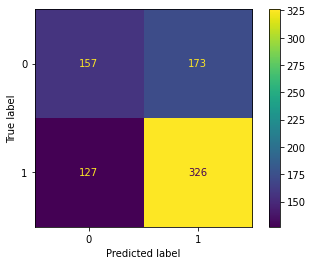

In [43]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 16)
rfc.fit(X_train_rfc, y_train)
y_pred_rfc = rfc.predict(X_test_rfc)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_rfc))
conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rfc))
conf_mat.plot()
plt.show()

# 4. Doc2Vec

In [143]:
# Creating the document vectors matrix
docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(stemmed_corpus)]
model_d2v = Doc2Vec(docs, vector_size=100, window=2, min_count=1, workers=4)
doc_mat = [model_d2v.dv[i] for i in range(len(stemmed_corpus))]

In [144]:
# Train-valid-test split
X_train_d2v = doc_mat[:df_train.shape[0]]
X_valid_d2v= doc_mat[df_train.shape[0]:-df_test.shape[0]]
X_test_d2v = doc_mat[-df_test.shape[0]:]

## 4.1 Support Vector Machine with linear kernel

In [145]:
# Hyperparameter tuning of the cost parameter with validation set approach and grid search.
grid_params = []
for cost in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    svm = SVC(kernel='linear', C = cost)
    svm.fit(X_train_d2v, y_train)
    y_pred_d2v_valid = svm.predict(X_valid_d2v)
    acc = accuracy_score(y_valid, y_pred_d2v_valid)
    grid_params.append((cost, acc))
    print(f"ACCURACY SCORE with C = {cost} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with C = ", best_param)

ACCURACY SCORE with C = 0.001 is: 0.5277078085642317
ACCURACY SCORE with C = 0.01 is: 0.5277078085642317
ACCURACY SCORE with C = 0.1 is: 0.5277078085642317
ACCURACY SCORE with C = 1 is: 0.5277078085642317
ACCURACY SCORE with C = 10 is: 0.5277078085642317
ACCURACY SCORE with C = 100 is: 0.5642317380352645
ACCURACY SCORE with C = 1000 is: 0.5642317380352645
The maximum accuracy is reached with C =  100


#### Predicting on the test set

Accuracy:  0.5925925925925926


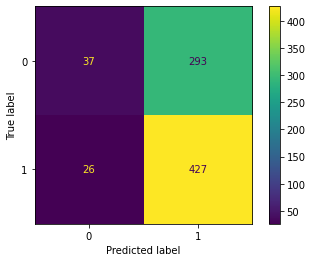

In [146]:
svm = SVC(kernel='linear', C = best_param) # we select the best cost parameter according to our grid search above
svm.fit(X_train_d2v, y_train)
y_pred_d2v = svm.predict(X_test_d2v)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_d2v))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_d2v))
conf_mat.plot()
plt.show()

## 4.2 Random Forest 

#### Hyperparameter tuning

In [148]:
# Hyperparameter tuning 
grid_params = []
for n_trees in [50, 100, 200, 500, 1000]:
        rfc = RandomForestClassifier(n_estimators = n_trees, random_state = 16)
        rfc.fit(X_train_d2v, y_train)
        y_pred_d2v_valid = rfc.predict(X_valid_d2v)
        acc = accuracy_score(y_valid, y_pred_d2v_valid)
        grid_params.append((n_trees, acc))
        print(f"ACCURACY SCORE with N_TREES = {n_trees} is: {acc}")

best_param = max(grid_params, key = lambda x: x[1])[0]
print("The maximum accuracy is reached with n_trees = ", best_param)

ACCURACY SCORE with N_TREES = 50 is: 0.575566750629723
ACCURACY SCORE with N_TREES = 100 is: 0.5856423173803527
ACCURACY SCORE with N_TREES = 200 is: 0.5780856423173804
ACCURACY SCORE with N_TREES = 500 is: 0.570528967254408
ACCURACY SCORE with N_TREES = 1000 is: 0.570528967254408
The maximum accuracy is reached with n_trees =  100


#### Predicting on the test set

Accuracy:  0.5964240102171137


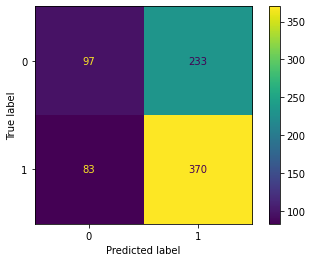

In [149]:
rfc = RandomForestClassifier(n_estimators = best_param, random_state = 16)
rfc.fit(X_train_d2v, y_train)
y_pred_d2v = rfc.predict(X_test_d2v)

# Test accuracy
print("Accuracy: ", accuracy_score(y_test, y_pred_d2v))

conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_d2v))
conf_mat.plot()
plt.show()